In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import netCDF4 as nc
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [2]:
import sys

sys.path.insert(0, '/data/SO2/SO24/ANDY/SOHI/Utils')
import Andy

In [3]:
## Generate grid 

## Aproximately 1/2 deg longitude by 1/5 deg latitude by 20 m depth
### 22km by 23 km at -65 
### 22km by 19 km at -70
### 22 km by 14 km at -75

XC = np.arange(-179.75, 180, 0.5)
YC = np.arange(-89.9, -55, 0.2)
RC = np.arange(-10, -3000, -20)

In [4]:
def interpolate3D(X, Y, Z, data, refX = XC, refY = YC, refZ = RC):
    grid = np.zeros((len(RC), len(YC), len(XC)))
    
    for i in tqdm(range(len(refY))):
        iy = np.argmin(abs(Y - refY[i]))
        for j in range(len(refX)):
            ix = np.argmin(abs(X - refX[j]))
            
            for k in range(len(refZ)):
                iz = np.argmin(abs(Z - refZ))
                
                grid[k, i, j] = data[iz, iy, ix]
                
    grid[grid==0] = np.nan
    return grid

In [5]:
def interpolate2D(X, Y, data, refX = XC, refY = YC):
    grid = np.zeros((len(YC), len(XC)))
    
    for i in tqdm(range(len(refY))):
        iy = np.argmin(abs(Y - refY[i]))
        for j in range(len(refX)):
            ix = np.argmin(abs(X - refX[j]))
            
            grid[i, j] = data[iy, ix]
                
    grid[grid==0] = np.nan
    return grid

In [6]:
BATH, X, Y = Andy.loads.sohi_meta('bathymetry')
ICE, X, Y = Andy.loads.sohi_meta('icedraft')

In [7]:
ICE[ICE==0] = np.nan
ICE[~np.isnan(ICE)] = 1

In [8]:
np.save('IS.npy', ICE)
np.save('ISX.npy', X)
np.save('ISY.npy', Y)

In [9]:
ICE[ICE==0] = np.nan
np.nanmean(ICE)

1.0

In [10]:
mask = np.load('/data/SO2/SO24/ANDY/SOHI/Notebooks/1_SOHI_Eval/99_HeatTransport_Eval/data_stair_stepping/SOHI_mask.npy')

In [11]:
resampled_mask = interpolate2D(X%360, Y, mask, refX = np.arange(0, 360, 0.5))
resampled_bath = interpolate2D(X%360, Y, BATH, refX = np.arange(0, 360, 0.5))
resampled_ice = interpolate2D(X%360, Y, ICE, refX = np.arange(0, 360, 0.5))
resampled_bath[np.isnan(resampled_mask)] = np.nan
resampled_ice[resampled_ice ==0] = np.nan
resampled_ice[~np.isnan(resampled_ice)] = 1

100%|█████████████████████████████████████████████████████| 175/175 [00:00<00:00, 178.61it/s]


In [116]:
np.save("data5_HalfDegRegridded/Bathymetry.npy", resampled_bath)
np.save("data5_HalfDegRegridded/Mask.npy", resampled_mask)

## Bin MEOP Bias to Grid

In [12]:
## Load MEOP
MEOP = np.load(f'data/interpolated/01.npy')

for fn in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    data = np.load(f'data/interpolated/{fn:02d}.npy')
    MEOP = np.concatenate((MEOP, data), axis=0)
    
## 0 Lat, 1 Lon, 2 Depth, 3 Region_Number, 
## 4 MEOP_T, 5 MEOP_S, 6 SOHI_T, 7 SOHI_S, 8 LLC4320_T, 9 LLC_4320_S, 
## 10 SOSE_T, 11 SOSE_S, 12 ECCO T, 13 ECCO S, 14 ISMIP6 T, 15 ISMIP6 S

### Mean Bias

In [72]:
dataT = [np.zeros((len(RC), len(YC), len(XC))) for i in range(4)]
countT = [np.zeros((len(RC), len(YC), len(XC))) for i in range(4)]
dataS = [np.zeros((len(RC), len(YC), len(XC))) for i in range(4)]
countS = [np.zeros((len(RC), len(YC), len(XC))) for i in range(4)]

for p in tqdm(range(MEOP.shape[0])):
    lat = MEOP[p, 0]
    lon = MEOP[p, 1]
    dep = MEOP[p, 2]
    
    iz = np.argmin(abs(RC - dep))
    iy = np.argmin(abs(YC - lat))
    ix = np.argmin(abs(XC - lon))
    
    Tindex = [6, 8, 10, 12]
    for m in range(len(Tindex)):
        err = MEOP[p,Tindex[m]] - MEOP[p, 4]
        if ~np.isnan(err):
            dataT[m][iz, iy, ix] += err
            countT[m][iz, iy, ix] += 1
                   
    Sindex = [7, 9, 11, 13]
    for m in range(len(Sindex)):
        err = MEOP[p,Sindex[m]] - MEOP[p, 5]
        if ~np.isnan(err):
            dataS[m][iz, iy, ix] += err
            countS[m][iz, iy, ix] += 1
                   

SOhiT = dataT[0] / countT[0]
SOhiS = dataS[0] / countS[0]
                   
LLCT = dataT[1] / countT[1]
LLCS = dataS[1] / countS[1]  
                   
SOSET = dataT[2] / countT[2]
SOSES = dataS[2] / countS[2]  
                   
ECCOT = dataT[3] / countT[3]
ECCOS = dataS[3] / countS[3]  

100%|██████████████████████████████| 4453810/4453810 [03:01<00:00, 24592.09it/s]
/tmp/ipykernel_1913274/1092060876.py:30: RuntimeWarning: invalid value encountered in divide
  SOhiT = dataT[0] / countT[0]
/tmp/ipykernel_1913274/1092060876.py:31: RuntimeWarning: invalid value encountered in divide
  SOhiS = dataS[0] / countS[0]
/tmp/ipykernel_1913274/1092060876.py:33: RuntimeWarning: invalid value encountered in divide
  LLCT = dataT[1] / countT[1]
/tmp/ipykernel_1913274/1092060876.py:34: RuntimeWarning: invalid value encountered in divide
  LLCS = dataS[1] / countS[1]
/tmp/ipykernel_1913274/1092060876.py:36: RuntimeWarning: invalid value encountered in divide
  SOSET = dataT[2] / countT[2]
/tmp/ipykernel_1913274/1092060876.py:37: RuntimeWarning: invalid value encountered in divide
  SOSES = dataS[2] / countS[2]
/tmp/ipykernel_1913274/1092060876.py:39: RuntimeWarning: invalid value encountered in divide
  ECCOT = dataT[3] / countT[3]
/tmp/ipykernel_1913274/1092060876.py:40: RuntimeWarni

In [62]:
np.save("data5_HalfDegRegridded/SOhi_T.npy", SOhiT)
np.save("data5_HalfDegRegridded/SOhi_S.npy", SOhiS)
np.save("data5_HalfDegRegridded/LLC_T.npy", LLCT)
np.save("data5_HalfDegRegridded/LLC_S.npy", LLCS)
np.save("data5_HalfDegRegridded/SOSE_T.npy", SOSET)
np.save("data5_HalfDegRegridded/SOSE_S.npy", SOSES)
np.save("data5_HalfDegRegridded/ECCO_T.npy", ECCOT)
np.save("data5_HalfDegRegridded/ECCO_S.npy", ECCOS)

### T and S

In [91]:
dataT = [np.zeros((len(RC), len(YC), len(XC))) for i in range(5)]
countT = [np.zeros((len(RC), len(YC), len(XC))) for i in range(5)]
dataS = [np.zeros((len(RC), len(YC), len(XC))) for i in range(5)]
countS = [np.zeros((len(RC), len(YC), len(XC))) for i in range(5)]

for p in tqdm(range(MEOP.shape[0])):
    lat = MEOP[p, 0]
    lon = MEOP[p, 1]
    dep = MEOP[p, 2]
    
    iz = np.argmin(abs(RC - dep))
    iy = np.argmin(abs(YC - lat))
    ix = np.argmin(abs(XC - lon))
    
    Tindex = [4, 6, 8, 10, 12]
    for m in range(len(Tindex)):
        err = MEOP[p,Tindex[m]]
        if ~np.isnan(err):
            dataT[m][iz, iy, ix] += err
            countT[m][iz, iy, ix] += 1
                   
    Sindex = [5, 7, 9, 11, 13]
    for m in range(len(Sindex)):
        err = MEOP[p,Sindex[m]]
        if ~np.isnan(err):
            dataS[m][iz, iy, ix] += err
            countS[m][iz, iy, ix] += 1

meopT = dataT[0] / countT[0]
meopS = dataS[0] / countS[0]

SOhiT = dataT[1] / countT[1]
SOhiS = dataS[1] / countS[1]
                   
LLCT = dataT[2] / countT[2]
LLCS = dataS[2] / countS[2]  
                   
SOSET = dataT[3] / countT[3]
SOSES = dataS[3] / countS[3]  
                   
ECCOT = dataT[4] / countT[4]
ECCOS = dataS[4] / countS[4] 

100%|██████████████████████████████████████████████| 4453810/4453810 [03:18<00:00, 22417.06it/s]
/tmp/ipykernel_106648/619959153.py:29: RuntimeWarning: invalid value encountered in divide
  meopT = dataT[0] / countT[0]
/tmp/ipykernel_106648/619959153.py:30: RuntimeWarning: invalid value encountered in divide
  meopS = dataS[0] / countS[0]
/tmp/ipykernel_106648/619959153.py:32: RuntimeWarning: invalid value encountered in divide
  SOhiT = dataT[1] / countT[1]
/tmp/ipykernel_106648/619959153.py:33: RuntimeWarning: invalid value encountered in divide
  SOhiS = dataS[1] / countS[1]
/tmp/ipykernel_106648/619959153.py:35: RuntimeWarning: invalid value encountered in divide
  LLCT = dataT[2] / countT[2]
/tmp/ipykernel_106648/619959153.py:36: RuntimeWarning: invalid value encountered in divide
  LLCS = dataS[2] / countS[2]
/tmp/ipykernel_106648/619959153.py:38: RuntimeWarning: invalid value encountered in divide
  SOSET = dataT[3] / countT[3]
/tmp/ipykernel_106648/619959153.py:39: RuntimeWarni

In [92]:
np.save("data1/meop_T.npy", meopT)
np.save("data1/meop_S.npy", meopS)

np.save("data1/SOhi_T.npy", SOhiT)
np.save("data1/SOhi_S.npy", SOhiS)

np.save("data1/LLC_T.npy", LLCT)
np.save("data1/LLC_S.npy", LLCS)

np.save("data1/SOSE_T.npy", SOSET)
np.save("data1/SOSE_S.npy", SOSES)

np.save("data1/ECCO_T.npy", ECCOT)
np.save("data1/ECCO_S.npy", ECCOS)

### RMSE

In [13]:
dataT = [np.zeros((len(RC), len(YC), len(XC))) for i in range(4)]
countT = [np.zeros((len(RC), len(YC), len(XC))) for i in range(4)]
dataS = [np.zeros((len(RC), len(YC), len(XC))) for i in range(4)]
countS = [np.zeros((len(RC), len(YC), len(XC))) for i in range(4)]

for p in tqdm(range(MEOP.shape[0])):
    lat = MEOP[p, 0]
    lon = MEOP[p, 1]
    dep = MEOP[p, 2]
    
    iz = np.argmin(abs(RC - dep))
    iy = np.argmin(abs(YC - lat))
    ix = np.argmin(abs(XC - lon))
    
    Tindex = [6, 8, 10, 12]
    for m in range(len(Tindex)):
        err = (MEOP[p,Tindex[m]] - MEOP[p, 4])**2
        if ~np.isnan(err):
            dataT[m][iz, iy, ix] += err
            countT[m][iz, iy, ix] += 1
                   
    Sindex = [7, 9, 11, 13]
    for m in range(len(Sindex)):
        err = (MEOP[p,Sindex[m]] - MEOP[p, 5])**2
        if ~np.isnan(err):
            dataS[m][iz, iy, ix] += err
            countS[m][iz, iy, ix] += 1
                   

SOhiT = np.sqrt(dataT[0] / countT[0])
SOhiS = np.sqrt(dataS[0] / countS[0])

                   
LLCT = np.sqrt(dataT[1] / countT[1])
LLCS = np.sqrt(dataS[1] / countS[1]) 
                   
SOSET = np.sqrt(dataT[2] / countT[2])
SOSES = np.sqrt(dataS[2] / countS[2])  
                   
ECCOT = np.sqrt(dataT[3] / countT[3])
ECCOS = np.sqrt(dataS[3] / countS[3])

100%|███████████████████████████████████████████| 4453810/4453810 [02:59<00:00, 24793.50it/s]
/tmp/ipykernel_2125117/3373858322.py:30: RuntimeWarning: invalid value encountered in divide
  SOhiT = np.sqrt(dataT[0] / countT[0])
/tmp/ipykernel_2125117/3373858322.py:31: RuntimeWarning: invalid value encountered in divide
  SOhiS = np.sqrt(dataS[0] / countS[0])
/tmp/ipykernel_2125117/3373858322.py:34: RuntimeWarning: invalid value encountered in divide
  LLCT = np.sqrt(dataT[1] / countT[1])
/tmp/ipykernel_2125117/3373858322.py:35: RuntimeWarning: invalid value encountered in divide
  LLCS = np.sqrt(dataS[1] / countS[1])
/tmp/ipykernel_2125117/3373858322.py:37: RuntimeWarning: invalid value encountered in divide
  SOSET = np.sqrt(dataT[2] / countT[2])
/tmp/ipykernel_2125117/3373858322.py:38: RuntimeWarning: invalid value encountered in divide
  SOSES = np.sqrt(dataS[2] / countS[2])
/tmp/ipykernel_2125117/3373858322.py:40: RuntimeWarning: invalid value encountered in divide
  ECCOT = np.sqrt

In [18]:
np.save("data1/SOhi_RMSET.npy", SOhiT)
np.save("data1/SOhi_RMSES.npy", SOhiS)

np.save("data1/LLC_RMSET.npy", LLCT)
np.save("data1/LLC_RMSES.npy", LLCS)

np.save("data1/SOSE_RMSET.npy", SOSET)
np.save("data1/SOSE_RMSES.npy", SOSES)

np.save("data1/ECCO_RMSET.npy", ECCOT)
np.save("data1/ECCO_RMSES.npy", ECCOS)

## MEOP_1K_Isobath

In [11]:
def is_1k(lat, lon):
    iy = np.argmin(abs(Y - lat))
    ix = np.argmin(abs(X - lon))
    if mask[iy, ix] == 1:
        return True
    else:
        return False

In [12]:
## Load MEOP
MEOP = np.load(f'data/interpolated/01.npy')

for fn in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    data = np.load(f'data/interpolated/{fn:02d}.npy')
    MEOP = np.concatenate((MEOP, data), axis=0)
    
## 0 Lat, 1 Lon, 2 Depth, 3 Region_Number, 
## 4 MEOP_T, 5 MEOP_S, 6 SOHI_T, 7 SOHI_S, 8 LLC4320_T, 9 LLC_4320_S, 
## 10 SOSE_T, 11 SOSE_S, 12 ECCO T, 13 ECCO S, 14 ISMIP6 T, 15 ISMIP6 S

In [ ]:
index = []

for i in tqdm(range(MEOP.shape[0])):
    if is_1k(MEOP[i,0], MEOP[i, 1]):
        index.append(i)

In [ ]:
new_MEOP = np.zeros((len(index), MEOP.shape[1]))

for i in tqdm(range(len(index))):
    new_MEOP[i,:] = MEOP[index[i], :]

# Create MEOP Density Map

In [ ]:
depth1 = 0
depth2 = -200


Density = np.zeros((len(YC), len(XC)))

for p in tqdm(range(MEOP.shape[0])):
    lat = MEOP[p, 0]
    lon = MEOP[p, 1]
    dep = MEOP[p, 2]
    
    if dep <= depth1 and dep > depth2:
    
        iy = np.argmin(abs(YC - lat))
        ix = np.argmin(abs(XC - lon))


        if ~np.isnan(MEOP[p,4]):
            Density[iy, ix] += 1
    
    else:
        continue
        
np.save("data/density/regridded/Density_Map_000-200.npy", Density)

In [13]:
Density = np.load("data/regridded/Density_Map_ALL.npy")
Density = np.concatenate((Density[:, 360:], Density[:, :360]), axis=1)

Density[Density==0] = np.nan
Density = Density * resampled_mask

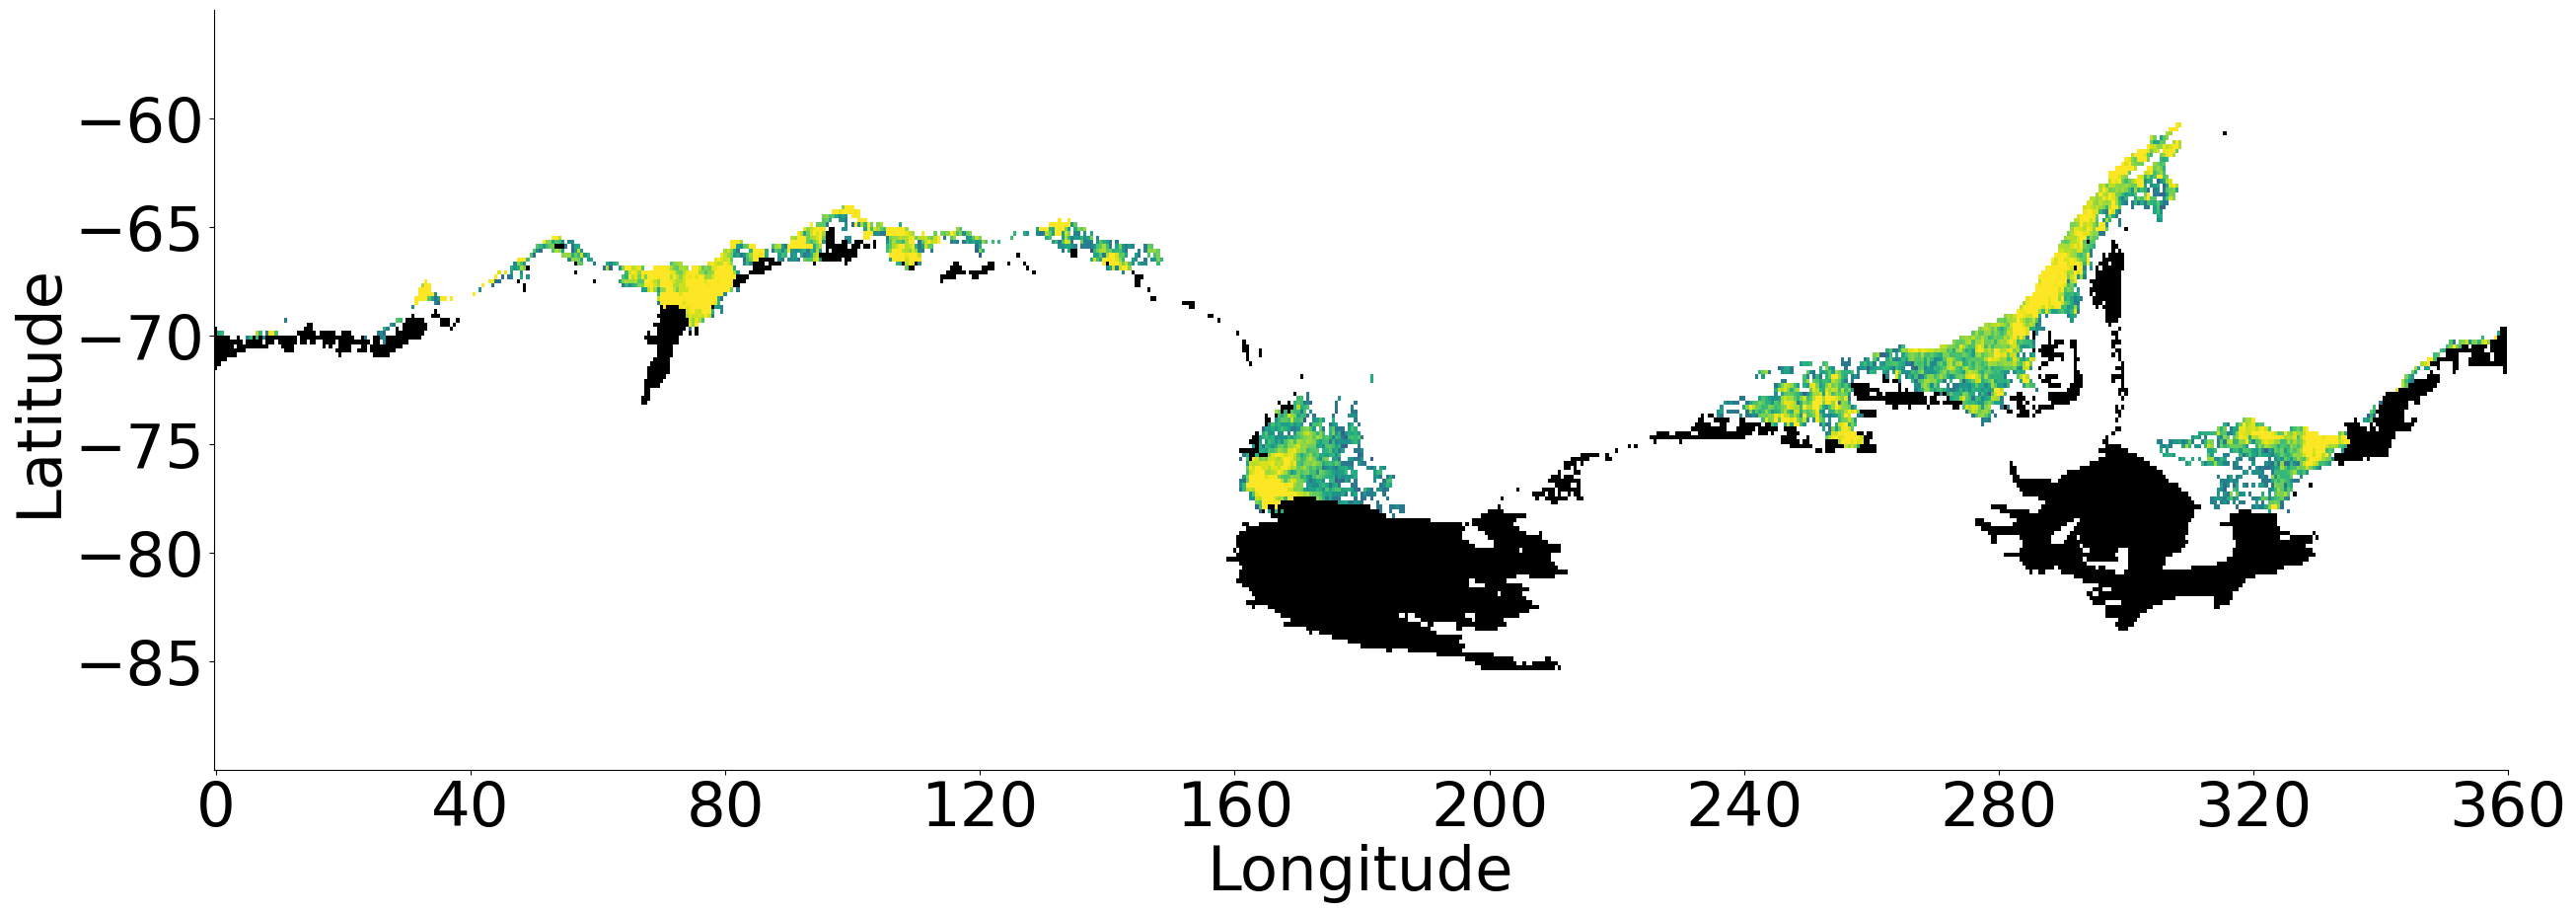

In [55]:
fig, ax = plt.subplots(figsize=(30,10))
im=ax.pcolormesh(np.arange(0, 360, 0.5), YC, Density, cmap='viridis', norm=matplotlib.colors.LogNorm(vmin=1, vmax=1000))
ax.pcolormesh(np.arange(0, 360, 0.5), YC, resampled_ice, cmap='gray')
# ax.contour(np.arange(0, 360, 0.5), YC, resampled_bath, levels=[2000, 10000])

# cbar_ax = fig.add_axes([0.15, 0.20, 0.3, 0.03])
# cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal', extend='max')
# # cbar.ax.set_xlabel(f'Number of Profiles', size=35)
# cbar.ax.tick_params(labelsize=40) 

ax.set_xlabel('Longitude', fontsize=45)
ax.set_ylabel('Latitude', fontsize=45)
ax.tick_params(axis='both', labelsize=45)

ax.spines['right'].set_color('None')
# ax.spines['left'].set_color('None')
ax.spines['top'].set_color('None')

ax.set_xticks(np.arange(0, 361, 40))
ax.set_yticks([-85, -80, -75, -70, -65, -60])

plt.savefig("img1_longitude_bias/Density.png", dpi=300)

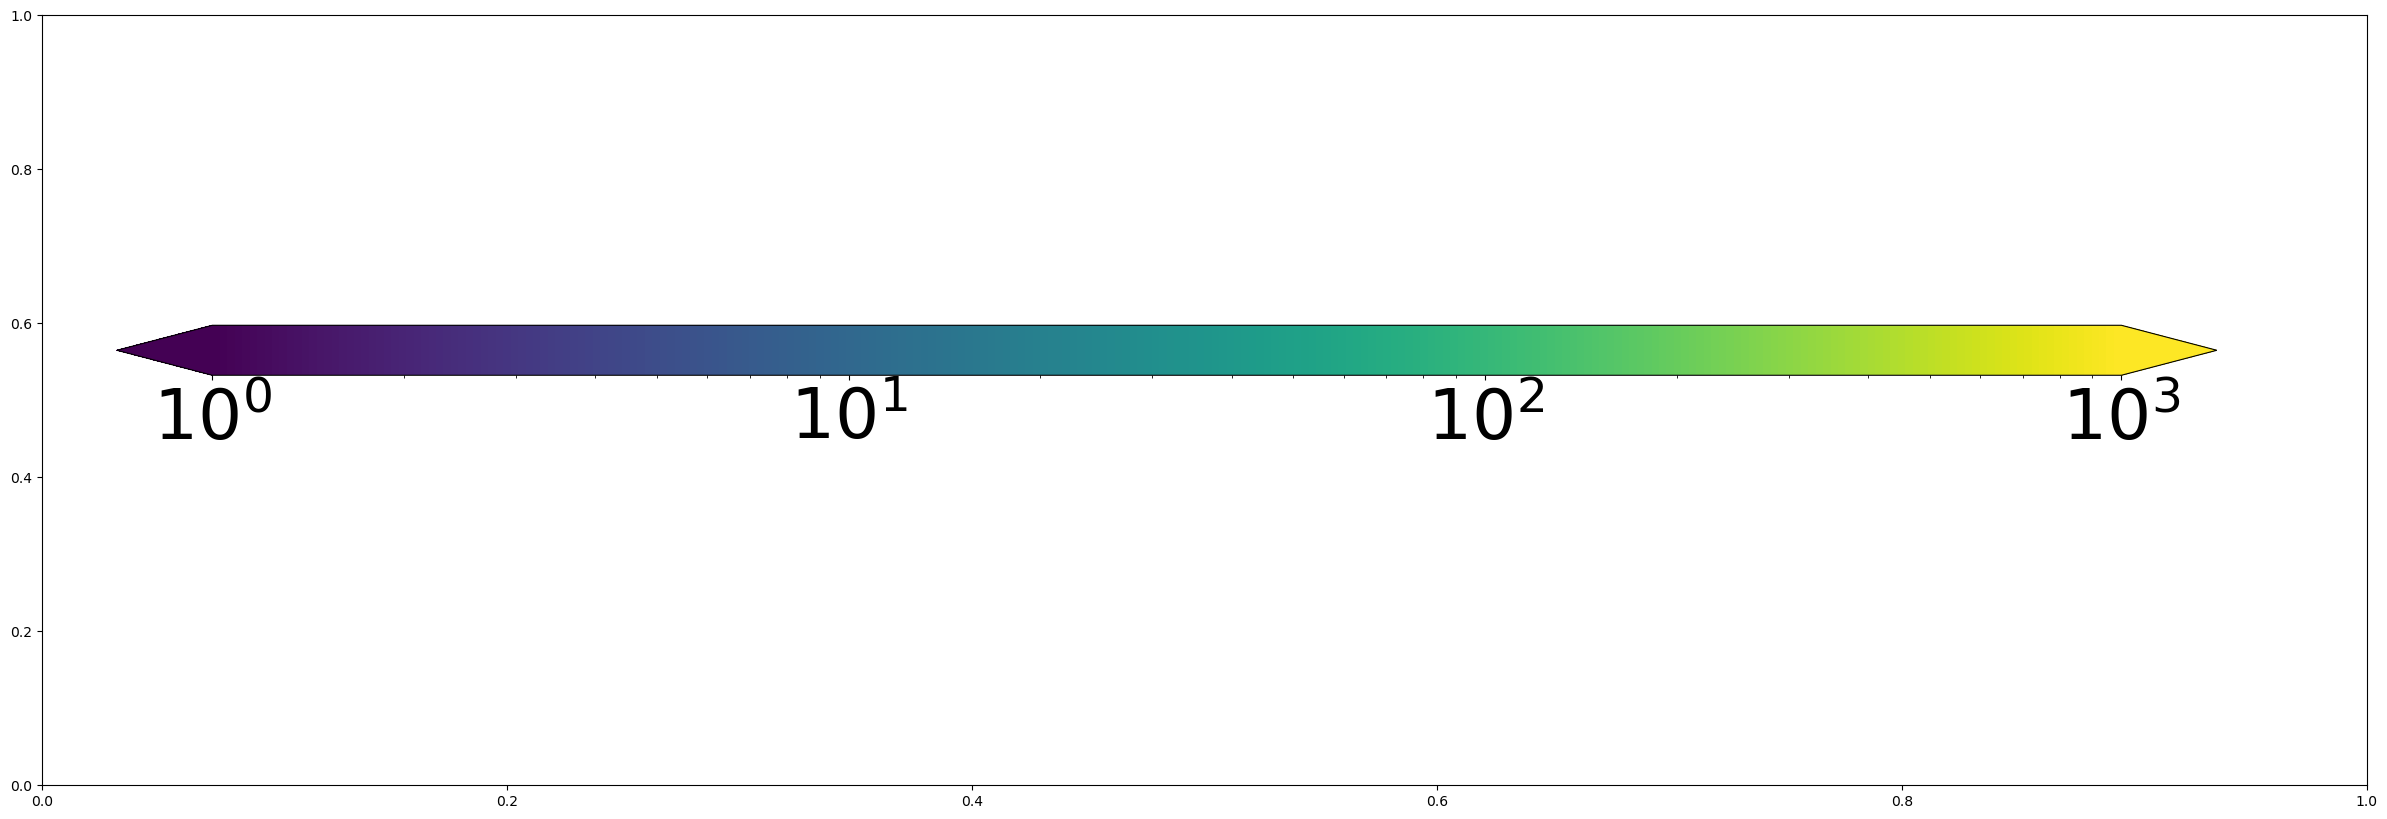

In [91]:
fig, ax = plt.subplots(figsize=(30,10))

cbar_ax = fig.add_axes([0.15, 0.52, 0.7, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal', extend='both')
#cbar.ax.set_xlabel(f' Mean Temperature Bias (C)', size=40)
cbar.ax.tick_params(labelsize=50) 



plt.savefig("img1_longitude_bias/Density_cb.png", dpi=300)

# Plot Mean Bias

In [6]:
def swap(data):
#     return data
    if data.ndim == 3:
        return np.concatenate((data[:,:, 360:], data[:,:, :360]), axis=2)
    else:
        return np.concatenate((data[:, 360:], data[:, :360]), axis=1)

In [7]:
SOhiT = swap(np.load("data/regridded/SOhi_T.npy"))
SOhiS = swap(np.load("data/regridded/SOhi_S.npy"))
LLCT = swap(np.load("data/regridded/LLC_T.npy"))
LLCS = swap(np.load("data/regridded/LLC_S.npy"))
SOSET = swap(np.load("data/regridded/SOSE_T.npy"))
SOSES = swap(np.load("data/regridded/SOSE_S.npy"))
ECCOT = swap(np.load("data/regridded/ECCO_T.npy"))
ECCOS = swap(np.load("data/regridded/ECCO_S.npy"))

resampled_mask = np.load("data/regridded/Mask.npy")

In [8]:
SOhiT = SOhiT * resampled_mask[None,:,:]
SOhiS = SOhiS * resampled_mask[None,:,:]

LLCT = LLCT * resampled_mask[None,:,:]
LLCS = LLCS * resampled_mask[None,:,:]

SOSET = SOSET * resampled_mask[None,:,:]
SOSES = SOSES * resampled_mask[None,:,:]

ECCOT = ECCOT * resampled_mask[None,:,:]
ECCOS = ECCOS * resampled_mask[None,:,:]

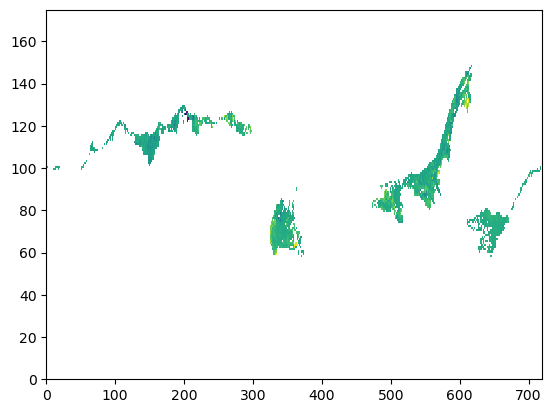

In [19]:
plt.pcolormesh(SOhiT[0])

# Bias 2D by Longitude-Depth

In [14]:
D2SOHI = np.nanmean(SOhiT, axis=(1))
D2LLC = np.nanmean(LLCT, axis=(1))
D2SOSE = np.nanmean(SOSET, axis=(1))
D2ECCO = np.nanmean(ECCOT, axis=(1))

/tmp/ipykernel_106648/2825666146.py:1: RuntimeWarning: Mean of empty slice
  D2SOHI = np.nanmean(SOhiT, axis=(1))
/tmp/ipykernel_106648/2825666146.py:2: RuntimeWarning: Mean of empty slice
  D2LLC = np.nanmean(LLCT, axis=(1))
/tmp/ipykernel_106648/2825666146.py:3: RuntimeWarning: Mean of empty slice
  D2SOSE = np.nanmean(SOSET, axis=(1))
/tmp/ipykernel_106648/2825666146.py:4: RuntimeWarning: Mean of empty slice
  D2ECCO = np.nanmean(ECCOT, axis=(1))


In [19]:
def nan_gaussian(arr, sigma=2.0, truncate = 4.0, masked_nan = True):

    V=arr.copy()
    V[np.isnan(arr)]=0
    VV=gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*arr.copy()+1
    W[np.isnan(arr)]=0
    WW=gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    
    if masked_nan:
        nanmask = np.ones(arr.shape)
        nanmask[np.isnan(arr)] = np.nan
        Z = Z * nanmask
        
    return Z

In [48]:
blurred = nan_gaussian(D2SOHI[:40,:], sigma=2)

/tmp/ipykernel_3904001/2678725413.py:11: RuntimeWarning: invalid value encountered in divide
  Z=VV/WW


In [51]:
RC[40]

-810

/tmp/ipykernel_3904001/2678725413.py:11: RuntimeWarning: invalid value encountered in divide
  Z=VV/WW


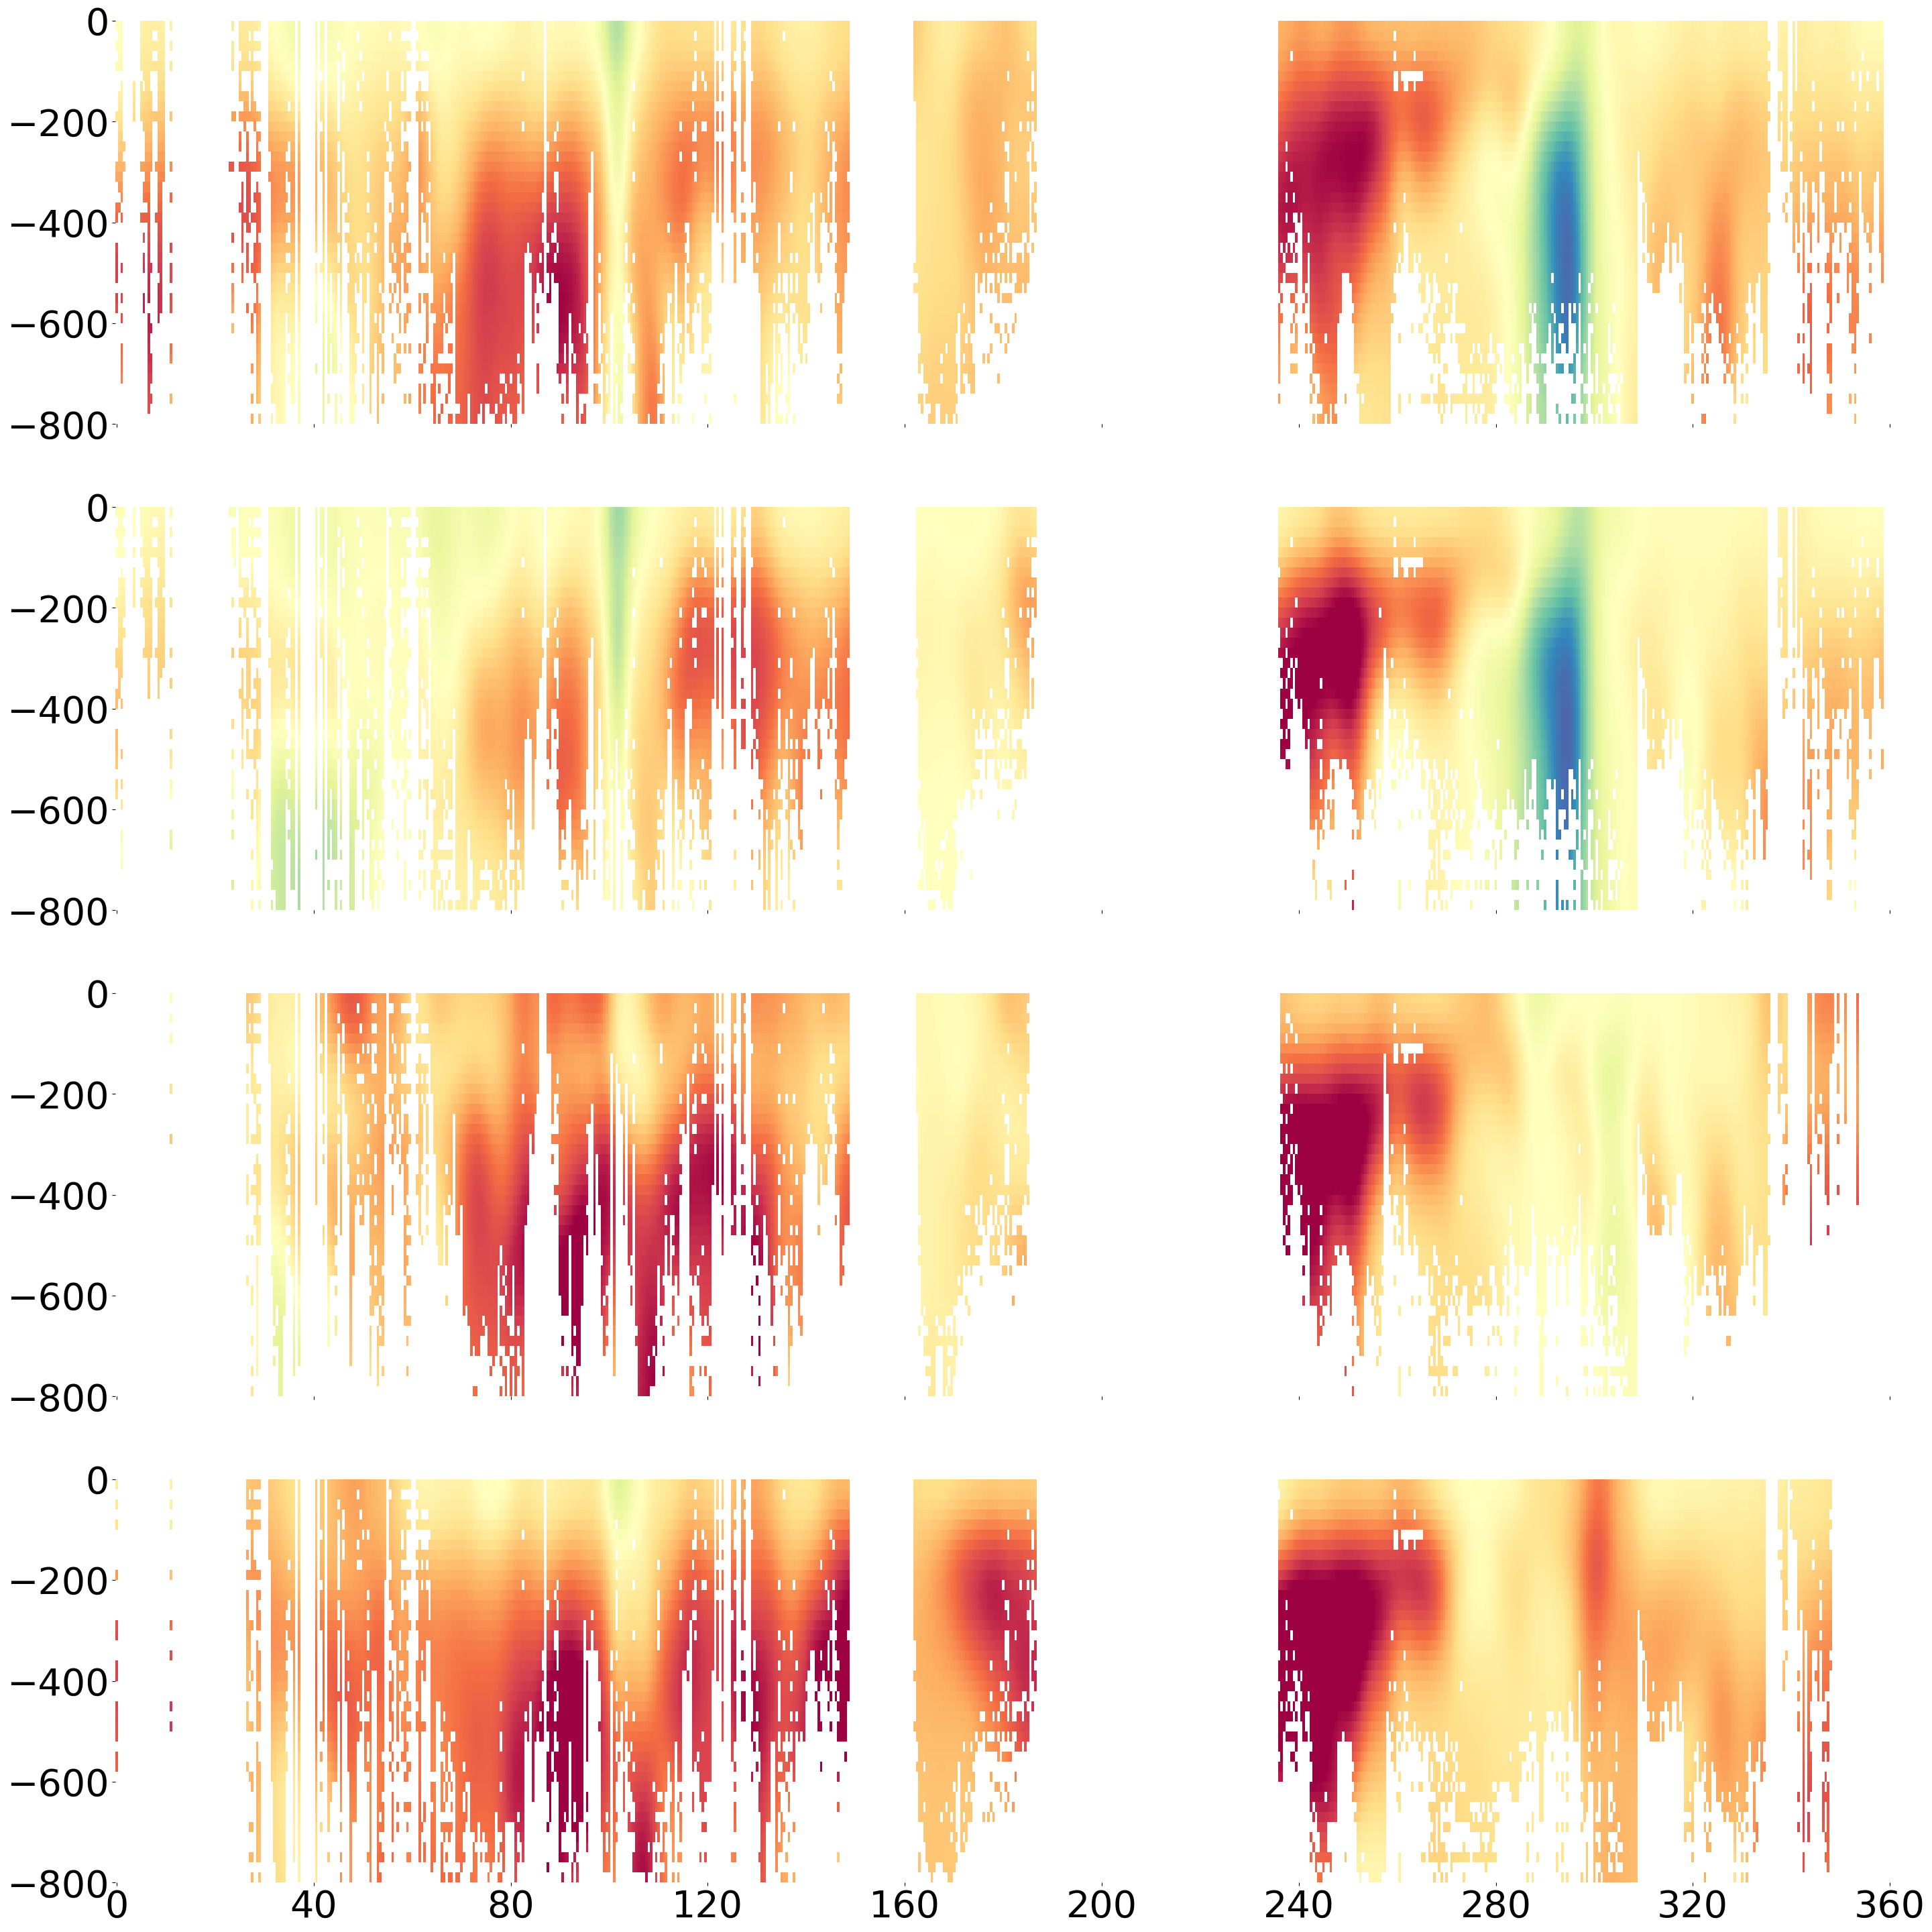

In [63]:
fig, ax = plt.subplots(figsize=(30,30), nrows=4, sharex=True)
im = ax[0].pcolormesh(np.arange(0,360, 0.5), RC[:40], nan_gaussian(D2SOHI[:40,:], sigma=4), 
                      vmin = -2, vmax = 2, cmap='Spectral_r')
ax[1].pcolormesh(np.arange(0,360, 0.5), RC[:40], nan_gaussian(D2LLC[:40,:], sigma=4), 
                 vmin = -2, vmax = 2, cmap='Spectral_r')
ax[2].pcolormesh(np.arange(0,360, 0.5), RC[:40], nan_gaussian(D2SOSE[:40,:], sigma=4), 
                 vmin = -2, vmax = 2, cmap='Spectral_r')
ax[3].pcolormesh(np.arange(0,360, 0.5), RC[:40], nan_gaussian(D2ECCO[:40,:], sigma=4), 
                 vmin = -2, vmax = 2, cmap='Spectral_r')

for a in ax.flat:
    a.spines['left'].set_color('None')
    a.spines['right'].set_color('None')
    a.spines['top'].set_color('None')
    a.spines['bottom'].set_color('None')
    a.tick_params(axis='y', labelsize=40)
    a.set_yticks([0,-200, -400, -600, -800])
#     a.grid(axis='x')

ax[3].set_xticks(np.arange(0, 361, 40))
ax[3].tick_params(axis='both', labelsize=40)
# ax[3].tick_params(axis='y', labelsize=40)

fig.tight_layout(pad=5.0)

plt.savefig("img1_longitude_bias/THETA_Gaussian_4.png", dpi=300)

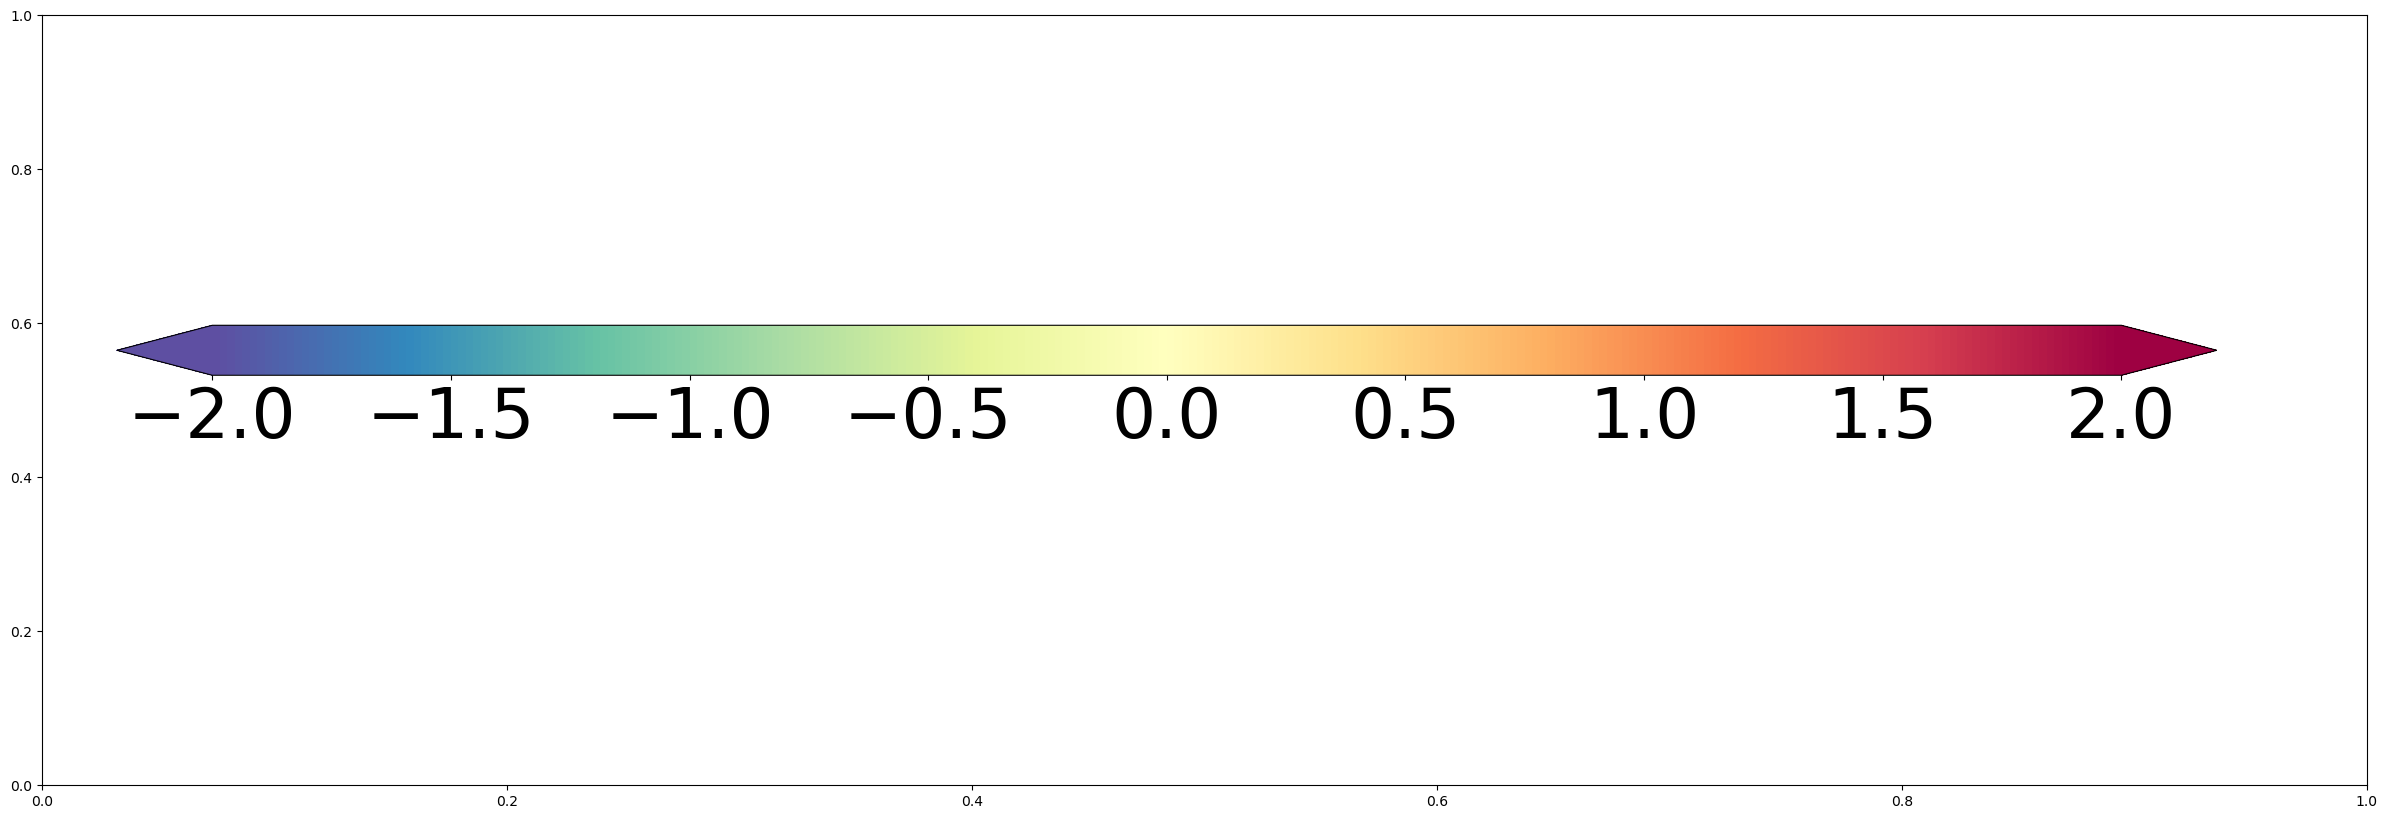

In [55]:
fig, ax = plt.subplots(figsize=(30,10))

cbar_ax = fig.add_axes([0.15, 0.52, 0.7, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal', extend='both')
# cbar.ax.set_xlabel(f' Mean Temperature Bias (C)', size=40)
cbar.ax.tick_params(labelsize=50) 



plt.savefig("img1_longitude_bias/Lon-Depth_cb.png", dpi=300)

In [64]:
D2SOHI = np.nanmean(SOhiS, axis=(1))
D2LLC = np.nanmean(LLCS, axis=(1))
D2SOSE = np.nanmean(SOSES, axis=(1))
D2ECCO = np.nanmean(ECCOS, axis=(1))

/tmp/ipykernel_3904001/1380762429.py:1: RuntimeWarning: Mean of empty slice
  D2SOHI = np.nanmean(SOhiS, axis=(1))
/tmp/ipykernel_3904001/1380762429.py:2: RuntimeWarning: Mean of empty slice
  D2LLC = np.nanmean(LLCS, axis=(1))
/tmp/ipykernel_3904001/1380762429.py:3: RuntimeWarning: Mean of empty slice
  D2SOSE = np.nanmean(SOSES, axis=(1))
/tmp/ipykernel_3904001/1380762429.py:4: RuntimeWarning: Mean of empty slice
  D2ECCO = np.nanmean(ECCOS, axis=(1))


/tmp/ipykernel_3904001/2678725413.py:11: RuntimeWarning: invalid value encountered in divide
  Z=VV/WW


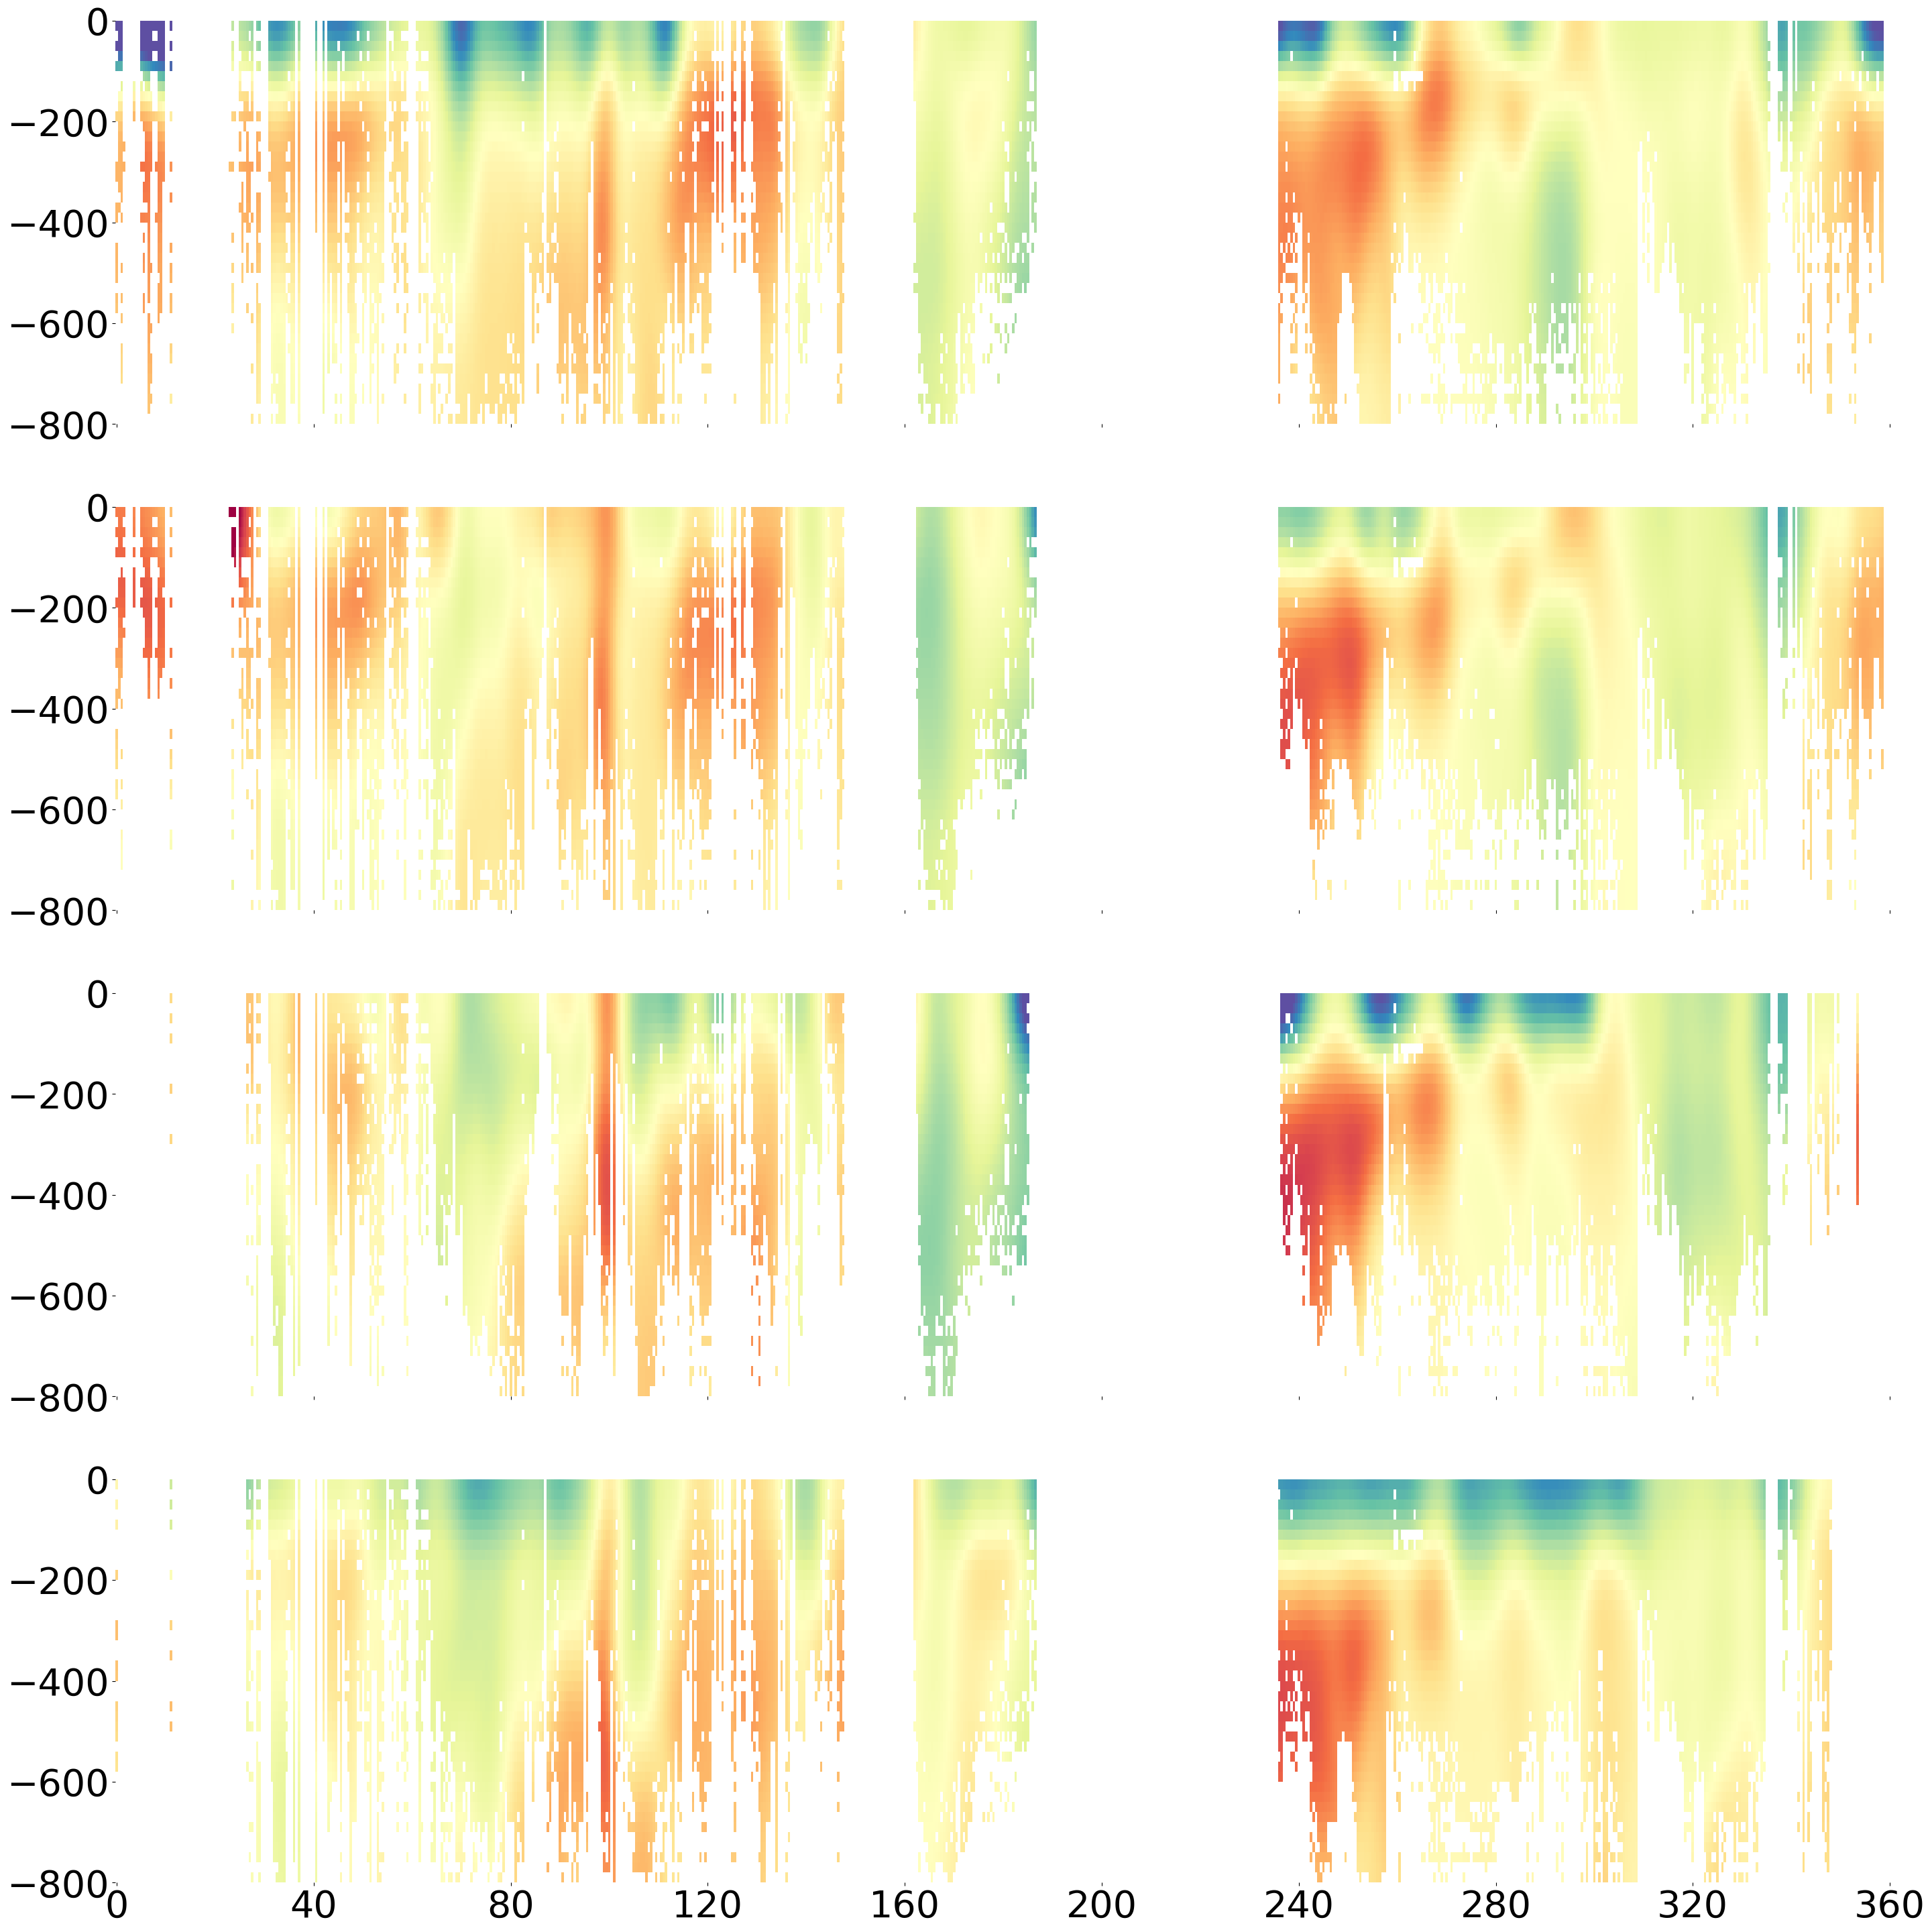

In [65]:
fig, ax = plt.subplots(figsize=(30,30), nrows=4, sharex=True)
im = ax[0].pcolormesh(np.arange(0,360, 0.5), RC[:40], nan_gaussian(D2SOHI[:40,:], sigma=4),
                      vmin = -0.5, vmax = 0.5, cmap='Spectral_r')
ax[1].pcolormesh(np.arange(0,360, 0.5), RC[:40], nan_gaussian(D2LLC[:40,:], sigma=4),
                 vmin = -0.5, vmax = 0.5, cmap='Spectral_r')
ax[2].pcolormesh(np.arange(0,360, 0.5), RC[:40], nan_gaussian(D2SOSE[:40,:], sigma=4),
                 vmin = -0.5, vmax = 0.5, cmap='Spectral_r')
ax[3].pcolormesh(np.arange(0,360, 0.5), RC[:40], nan_gaussian(D2ECCO[:40,:], sigma=4),
                 vmin = -0.5, vmax = 0.5, cmap='Spectral_r')

for a in ax.flat:
    a.spines['left'].set_color('None')
    a.spines['right'].set_color('None')
    a.spines['top'].set_color('None')
    a.spines['bottom'].set_color('None')
    a.tick_params(axis='y', labelsize=40)
    a.set_yticks([0,-200, -400, -600, -800])
#     a.grid(axis='x')

ax[3].set_xticks(np.arange(0, 361, 40))
ax[3].tick_params(axis='both', labelsize=40)
# ax[3].tick_params(axis='y', labelsize=40)

fig.tight_layout(pad=5.0)

plt.savefig("img1_longitude_bias/SALT_Gaussian_4.png", dpi=300)

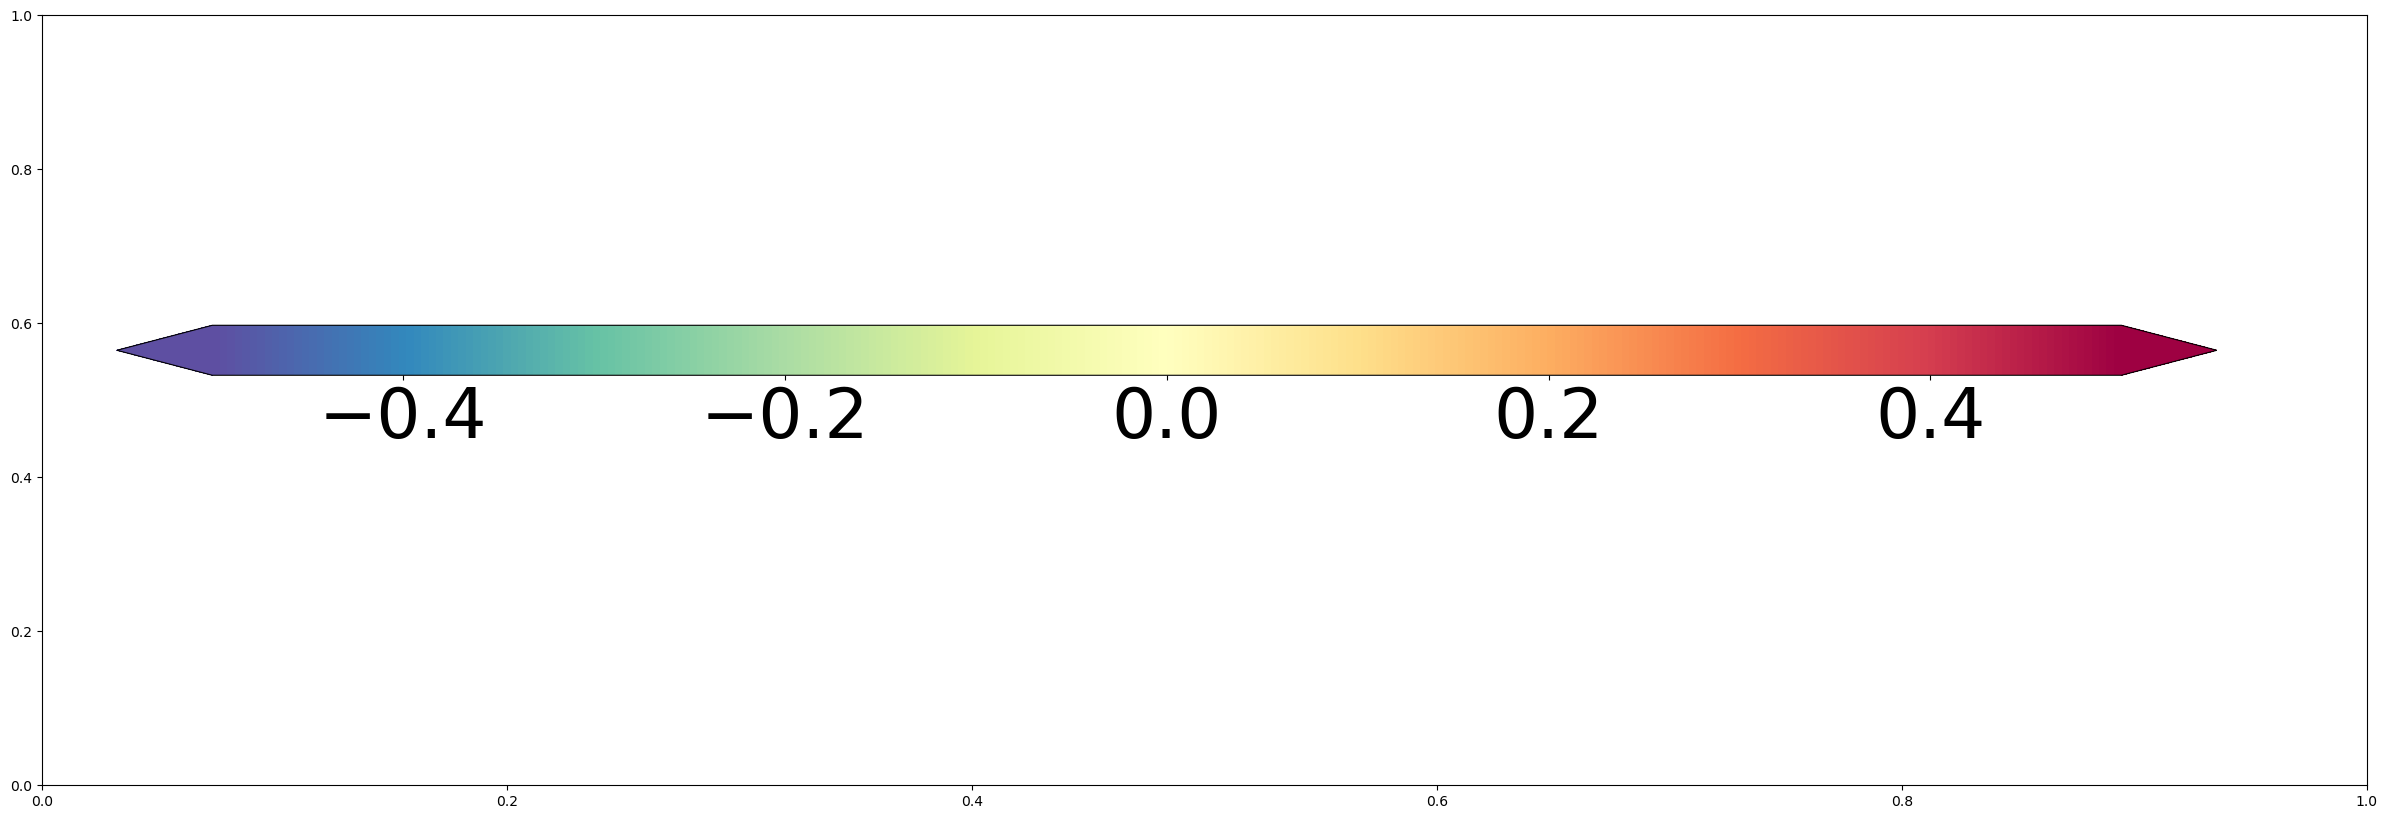

In [59]:
fig, ax = plt.subplots(figsize=(30,10))

cbar_ax = fig.add_axes([0.15, 0.52, 0.7, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal', extend='both')
# cbar.ax.set_xlabel(f' Mean Temperature Bias (C)', size=40)
cbar.ax.tick_params(labelsize=50) 



plt.savefig("img1_longitude_bias/SALT_Lon-Depth_cb.png", dpi=300)

# Mean Bias: Below 400 m

In [9]:
dsetT = [SOhiT, LLCT, SOSET, ECCOT]
dsetS = [SOhiS, LLCS, SOSES, ECCOS]
D2SOHI = np.nanmean(SOhiT, axis=(1))

/tmp/ipykernel_2620780/3375634705.py:3: RuntimeWarning: Mean of empty slice
  D2SOHI = np.nanmean(SOhiT, axis=(1))


/tmp/ipykernel_799766/2678725413.py:11: RuntimeWarning: invalid value encountered in divide
  Z=VV/WW


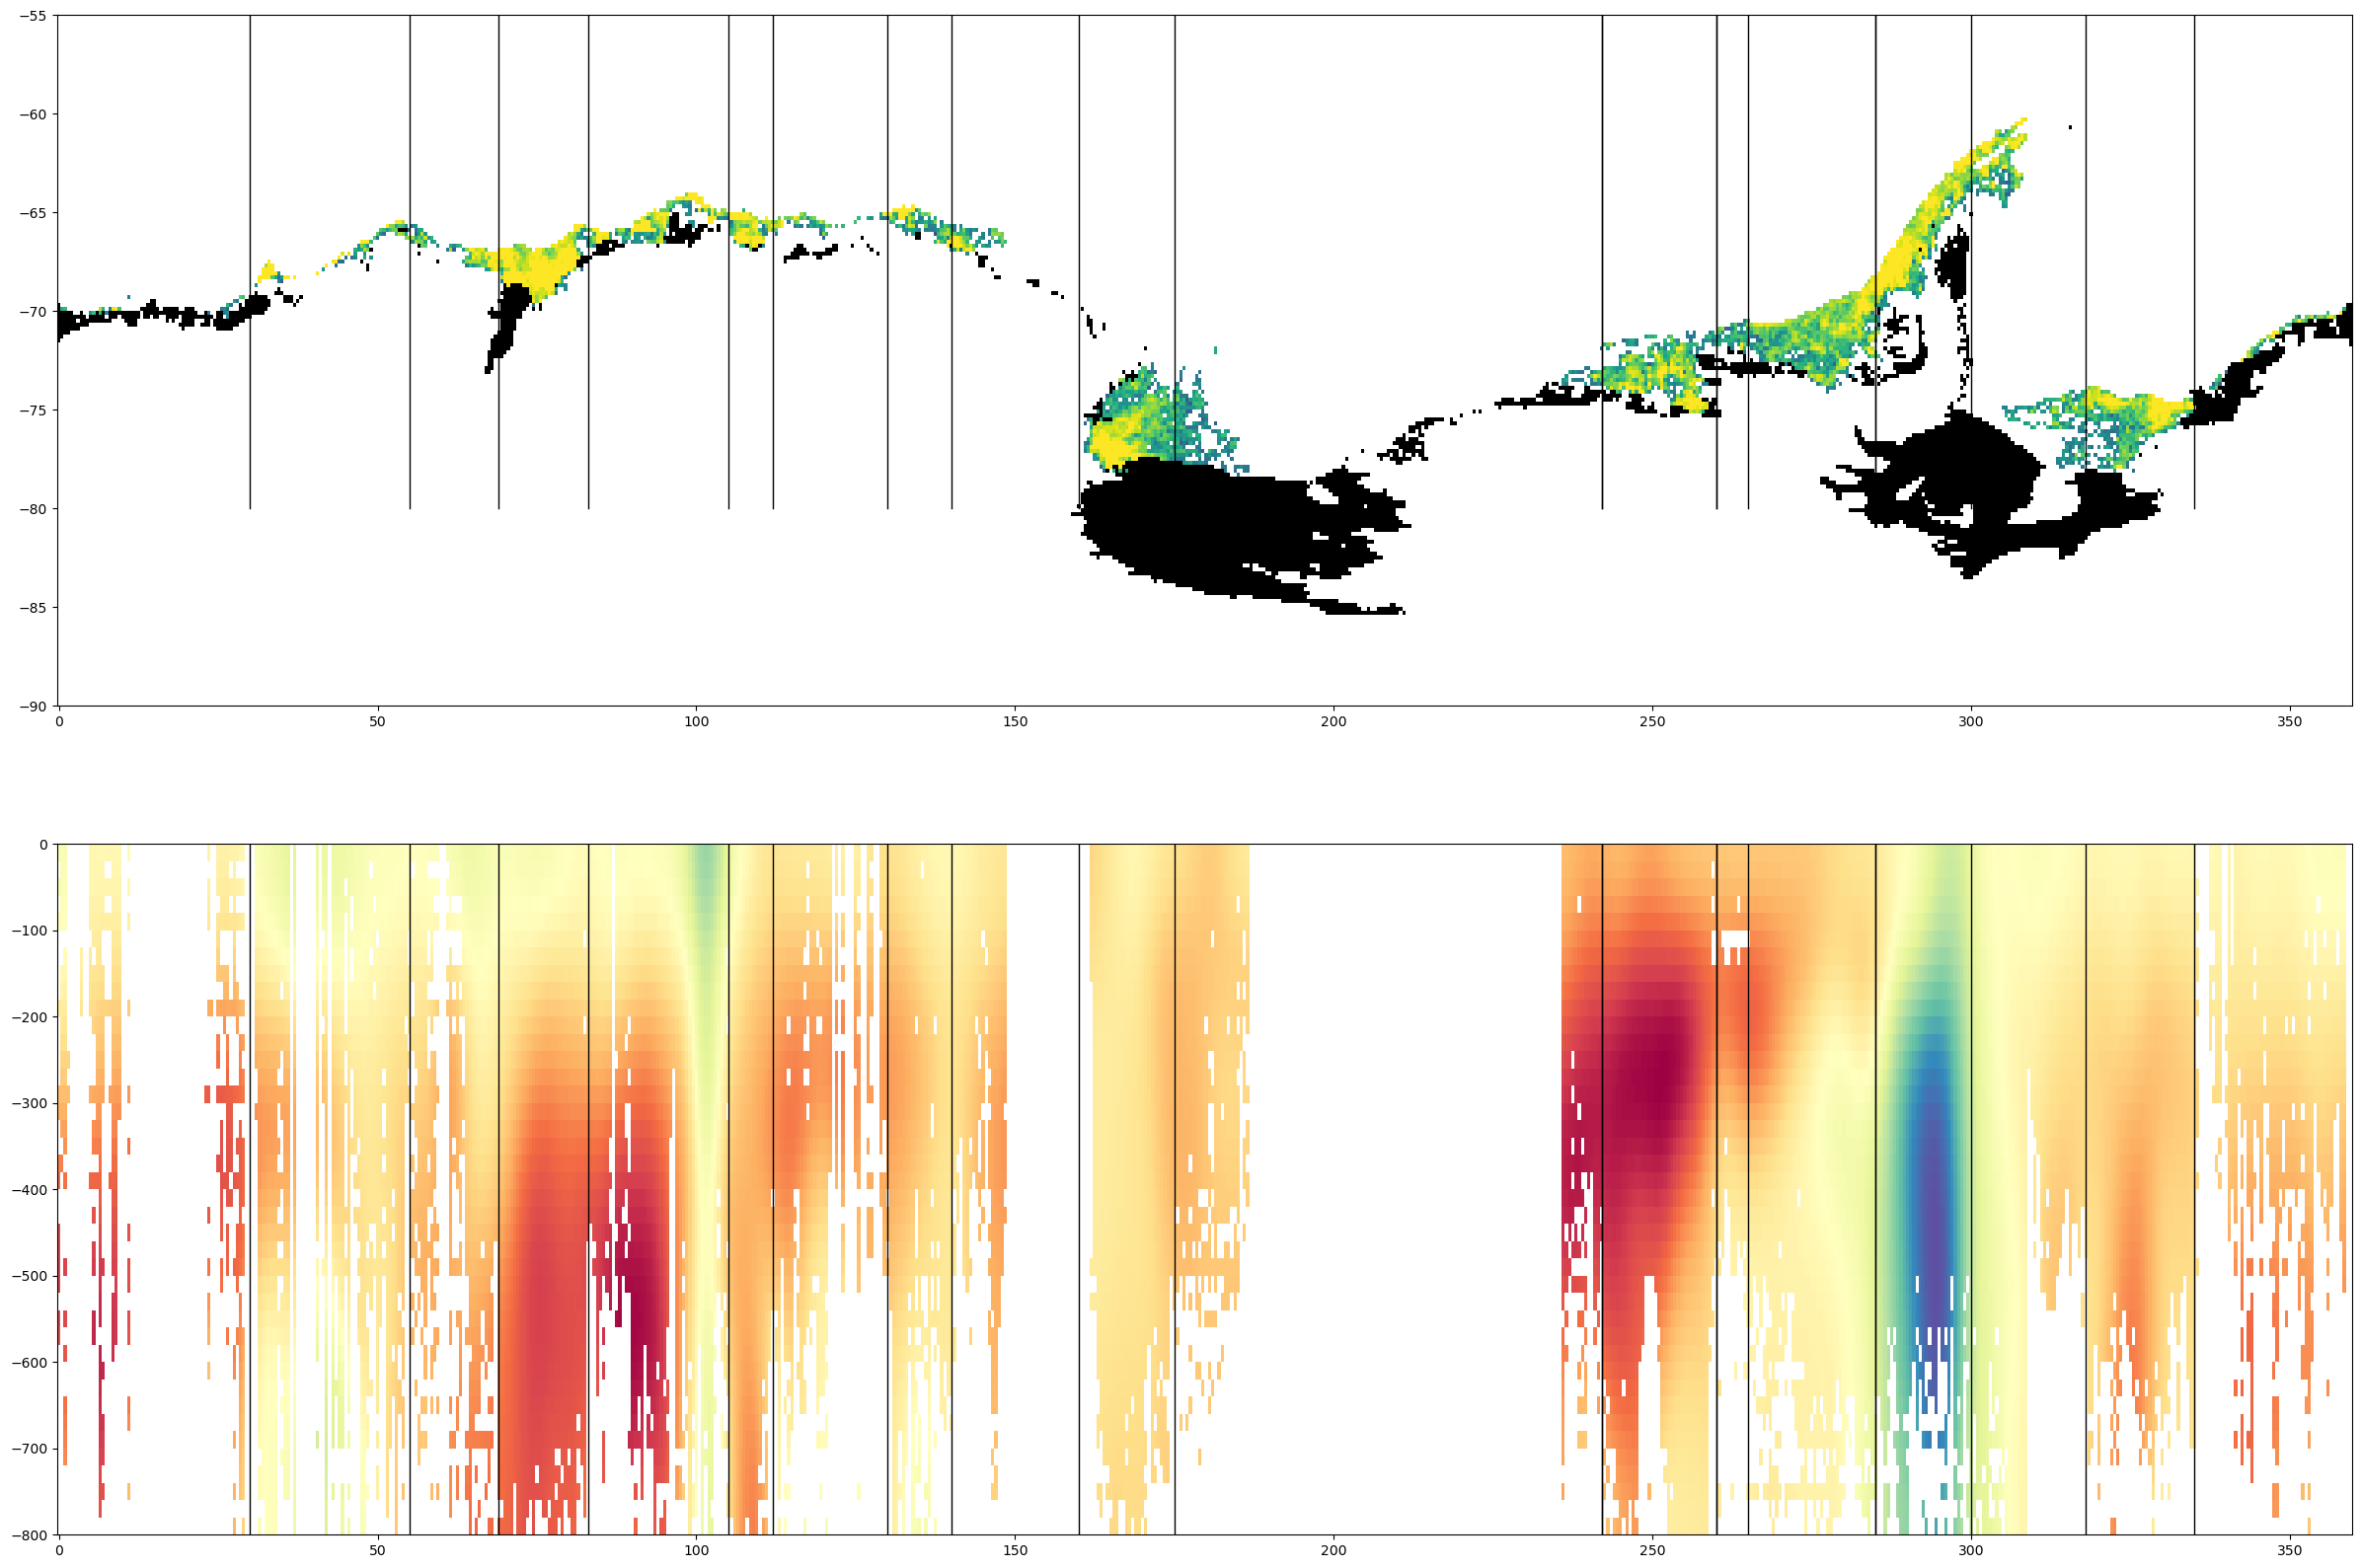

In [20]:
fig, ax = plt.subplots(figsize=(30,20), nrows=2)
im=ax[0].pcolormesh(np.arange(0, 360, 0.5), YC, Density, cmap='viridis', norm=matplotlib.colors.LogNorm(vmin=1, vmax=1000))
ax[0].pcolormesh(np.arange(0, 360, 0.5), YC, resampled_ice, cmap='gray')

ax[1].pcolormesh(np.arange(0, 360, 0.5), RC[:40], nan_gaussian(D2SOHI[:40,:], sigma=4), cmap='Spectral_r')

count = 0
for a in ax.flat:
    
    if count ==0:
        ybounds = [-80, -55]
    else:
        ybounds = [-800, 0]
    a.plot([30,30], ybounds, c='k', lw=1)
    a.plot([55,55], ybounds, c='k', lw=1)
    
    a.plot([69, 69], ybounds, c='k', lw=1)
    a.plot([83, 83], ybounds, c='k', lw=1)
    
    a.plot([105, 105], ybounds, c='k', lw=1)
    a.plot([112, 112], ybounds, c='k', lw=1)
    
    a.plot([130, 130], ybounds, c='k', lw=1)
    a.plot([140, 140], ybounds, c='k', lw=1)
    
    a.plot([160, 160], ybounds, c='k', lw=1)
    a.plot([175, 175], ybounds, c='k', lw=1)

    a.plot([242, 242], ybounds, c='k', lw=1)
    a.plot([260, 260], ybounds, c='k', lw=1)

    a.plot([242, 242], ybounds, c='k', lw=1)
    a.plot([260, 260], ybounds, c='k', lw=1)
    
    a.plot([265, 265], ybounds, c='k', lw=1)
    a.plot([285, 285], ybounds, c='k', lw=1)
    
    a.plot([285, 285], ybounds, c='k', lw=1)
    a.plot([300, 300], ybounds, c='k', lw=1)
    
    a.plot([318, 318], ybounds, c='k', lw=1)
    a.plot([335, 335], ybounds, c='k', lw=1)
    
    count += 1

In [10]:
def get(lon1, lon2):
    
    if lon1 < 0:
        lon1 = 360 - lon1
    if lon2 < 0:
        lon2 = 360 - lon2
        
    lon1 = lon1*2
    lon2 = lon2*2
    
    Tresult =[]
    Sresult = []
    
    for d in range(len(dsetT)):
        res1 = dsetT[d][20:,:, lon1:lon2]
        res2 = dsetS[d][20::,:,lon1:lon2]

        Tres = []
        Sres = []
        for k in tqdm(range(res1.shape[0])):
            for i in range(res1.shape[1]):
                for j in range(res1.shape[2]):
                    if ~np.isnan(res1[k, i, j]):
                        Tres.append(res1[k, i, j])
                    if ~np.isnan(res2[k, i, j]):
                        Sres.append(res2[k, i, j])

        Tresult.append(Tres)
        Sresult.append(Sres)
        
    return Tresult, Sresult

In [11]:
def running_mean(x, N):
    results = []
    hold = []
    
    for i in range(len(x)):
        hold.append(x[i])
        if len(hold) > N:
            hold.pop(0)
            
        results.append(np.nanmean(hold))
    
    return results

In [13]:
def show(lon1, lon2):
    Tres, Sres = get(lon1, lon2)
    print('Temperature')
    print(f'SOhi: {np.nanmean(Tres[0]):0.3f} +/- {np.nanstd(Tres[0]):0.3f}')
    print(f'LLC4320: {np.nanmean(Tres[1]):0.3f} +/- {np.nanstd(Tres[1]):0.3f}')
    print(f'SOSE: {np.nanmean(Tres[2]):0.3f} +/- {np.nanstd(Tres[2]):0.3f}')
    print(f'ECCO4: {np.nanmean(Tres[3]):0.3f} +/- {np.nanstd(Tres[3]):0.3f}')
    
    print('\nSalinity')
    print(f'SOhi: {np.nanmean(Sres[0]):0.3f} +/- {np.nanstd(Sres[0]):0.3f}')
    print(f'LLC4320: {np.nanmean(Sres[1]):0.3f} +/- {np.nanstd(Sres[1]):0.3f}')
    print(f'SOSE: {np.nanmean(Sres[2]):0.3f} +/- {np.nanstd(Sres[2]):0.3f}')
    print(f'ECCO4: {np.nanmean(Sres[3]):0.3f} +/- {np.nanstd(Sres[3]):0.3f}')

In [14]:
show(30, 55)

100%|██████████████████████████████████████████████████████| 130/130 [00:04<00:00, 32.40it/s]

Temperature
SOhi: 0.269 +/- 0.611
LLC4320: -0.349 +/- 0.553
SOSE: 0.209 +/- 0.682
ECCO4: 0.760 +/- 0.594

Salinity
SOhi: 0.014 +/- 0.084
LLC4320: -0.009 +/- 0.081
SOSE: -0.032 +/- 0.094
ECCO4: -0.019 +/- 0.084


In [15]:
show(69, 83)

100%|██████████████████████████████████████████████████████| 130/130 [00:02<00:00, 57.57it/s]

Temperature
SOhi: 1.464 +/- 0.460
LLC4320: 0.628 +/- 0.453
SOSE: 1.459 +/- 0.477
ECCO4: 1.395 +/- 0.409

Salinity
SOhi: 0.066 +/- 0.083
LLC4320: 0.058 +/- 0.066
SOSE: -0.006 +/- 0.104
ECCO4: -0.062 +/- 0.102


In [16]:
show(105, 112)

100%|█████████████████████████████████████████████████████| 130/130 [00:01<00:00, 113.11it/s]

Temperature
SOhi: 1.026 +/- 1.120
LLC4320: 0.560 +/- 0.927
SOSE: 1.719 +/- 0.907
ECCO4: 1.398 +/- 1.031

Salinity
SOhi: 0.106 +/- 0.091
LLC4320: 0.070 +/- 0.078
SOSE: 0.122 +/- 0.076
ECCO4: 0.070 +/- 0.138


In [17]:
show(130, 140)

100%|██████████████████████████████████████████████████████| 130/130 [00:01<00:00, 80.55it/s]

Temperature
SOhi: 0.400 +/- 0.478
LLC4320: 0.922 +/- 0.660
SOSE: 1.383 +/- 0.853
ECCO4: 1.568 +/- 0.563

Salinity
SOhi: 0.086 +/- 0.108
LLC4320: 0.092 +/- 0.110
SOSE: 0.108 +/- 0.144
ECCO4: 0.139 +/- 0.084


In [18]:
show(160, 175)

100%|██████████████████████████████████████████████████████| 130/130 [00:02<00:00, 53.94it/s]

Temperature
SOhi: 0.438 +/- 0.139
LLC4320: 0.025 +/- 0.095
SOSE: 0.219 +/- 0.189
ECCO4: 0.687 +/- 0.109

Salinity
SOhi: -0.103 +/- 0.096
LLC4320: -0.147 +/- 0.102
SOSE: -0.216 +/- 0.099
ECCO4: -0.002 +/- 0.096


In [19]:
show(242, 260)

100%|██████████████████████████████████████████████████████| 130/130 [00:02<00:00, 44.54it/s]

Temperature
SOhi: 0.939 +/- 0.669
LLC4320: 1.120 +/- 0.915
SOSE: 1.284 +/- 0.881
ECCO4: 1.252 +/- 0.935

Salinity
SOhi: 0.135 +/- 0.160
LLC4320: 0.179 +/- 0.167
SOSE: 0.200 +/- 0.164
ECCO4: 0.202 +/- 0.181


In [20]:
show(265, 285)

100%|██████████████████████████████████████████████████████| 130/130 [00:03<00:00, 40.24it/s]

Temperature
SOhi: 0.150 +/- 0.223
LLC4320: -0.089 +/- 0.272
SOSE: 0.323 +/- 0.173
ECCO4: 0.358 +/- 0.152

Salinity
SOhi: -0.027 +/- 0.042
LLC4320: -0.019 +/- 0.040
SOSE: 0.005 +/- 0.038
ECCO4: 0.037 +/- 0.036


In [21]:
show(285, 300)

100%|██████████████████████████████████████████████████████| 130/130 [00:02<00:00, 53.79it/s]

Temperature
SOhi: -1.160 +/- 0.616
LLC4320: -1.307 +/- 0.602
SOSE: 0.047 +/- 0.304
ECCO4: 0.307 +/- 0.318

Salinity
SOhi: -0.152 +/- 0.061
LLC4320: -0.136 +/- 0.065
SOSE: -0.009 +/- 0.037
ECCO4: 0.024 +/- 0.040


In [22]:
show(318, 335)

100%|██████████████████████████████████████████████████████| 130/130 [00:02<00:00, 48.04it/s]

Temperature
SOhi: 0.795 +/- 0.525
LLC4320: 0.359 +/- 0.412
SOSE: 0.477 +/- 0.462
ECCO4: 0.800 +/- 0.450

Salinity
SOhi: -0.039 +/- 0.081
LLC4320: -0.059 +/- 0.087
SOSE: -0.115 +/- 0.089
ECCO4: -0.016 +/- 0.090


# Deconstruct

In [77]:
resT = [[] for i in range(4)]
resS = [[] for i in range(4)]

dataT = [SOhiT, LLCT, SOSET, ECCOT ]
dataS = [SOhiS, LLCS, SOSES, ECCOS ]

for ds in tqdm(range(len(dataT))):
    T = dataT[ds]
    S = dataS[ds]
    for trange in [[0, 160*2], [220*2, 310*2]]:
        t1 = trange[0]
        t2 = trange[1]
        tempS = []
        tempT = []
        
        for i in range(SOhiT.shape[1]):
            for j in range(t1, t2):
                for z in range(20,SOhiT.shape[0]):
                    if ~np.isnan(T[z,i,j]) and ~np.isnan(S[z,i,j]):
                        tempT.append(T[z,i,j])
                        tempS.append(S[z,i,j])
                        
        resT[ds].append(tempT)
        resS[ds].append(tempS)
        del tempT
        del tempS
    

100%|██████████████████████████████████████████████████████████| 4/4 [01:19<00:00, 19.84s/it]


In [41]:
from numpy.polynomial.polynomial import polyfit, Polynomial

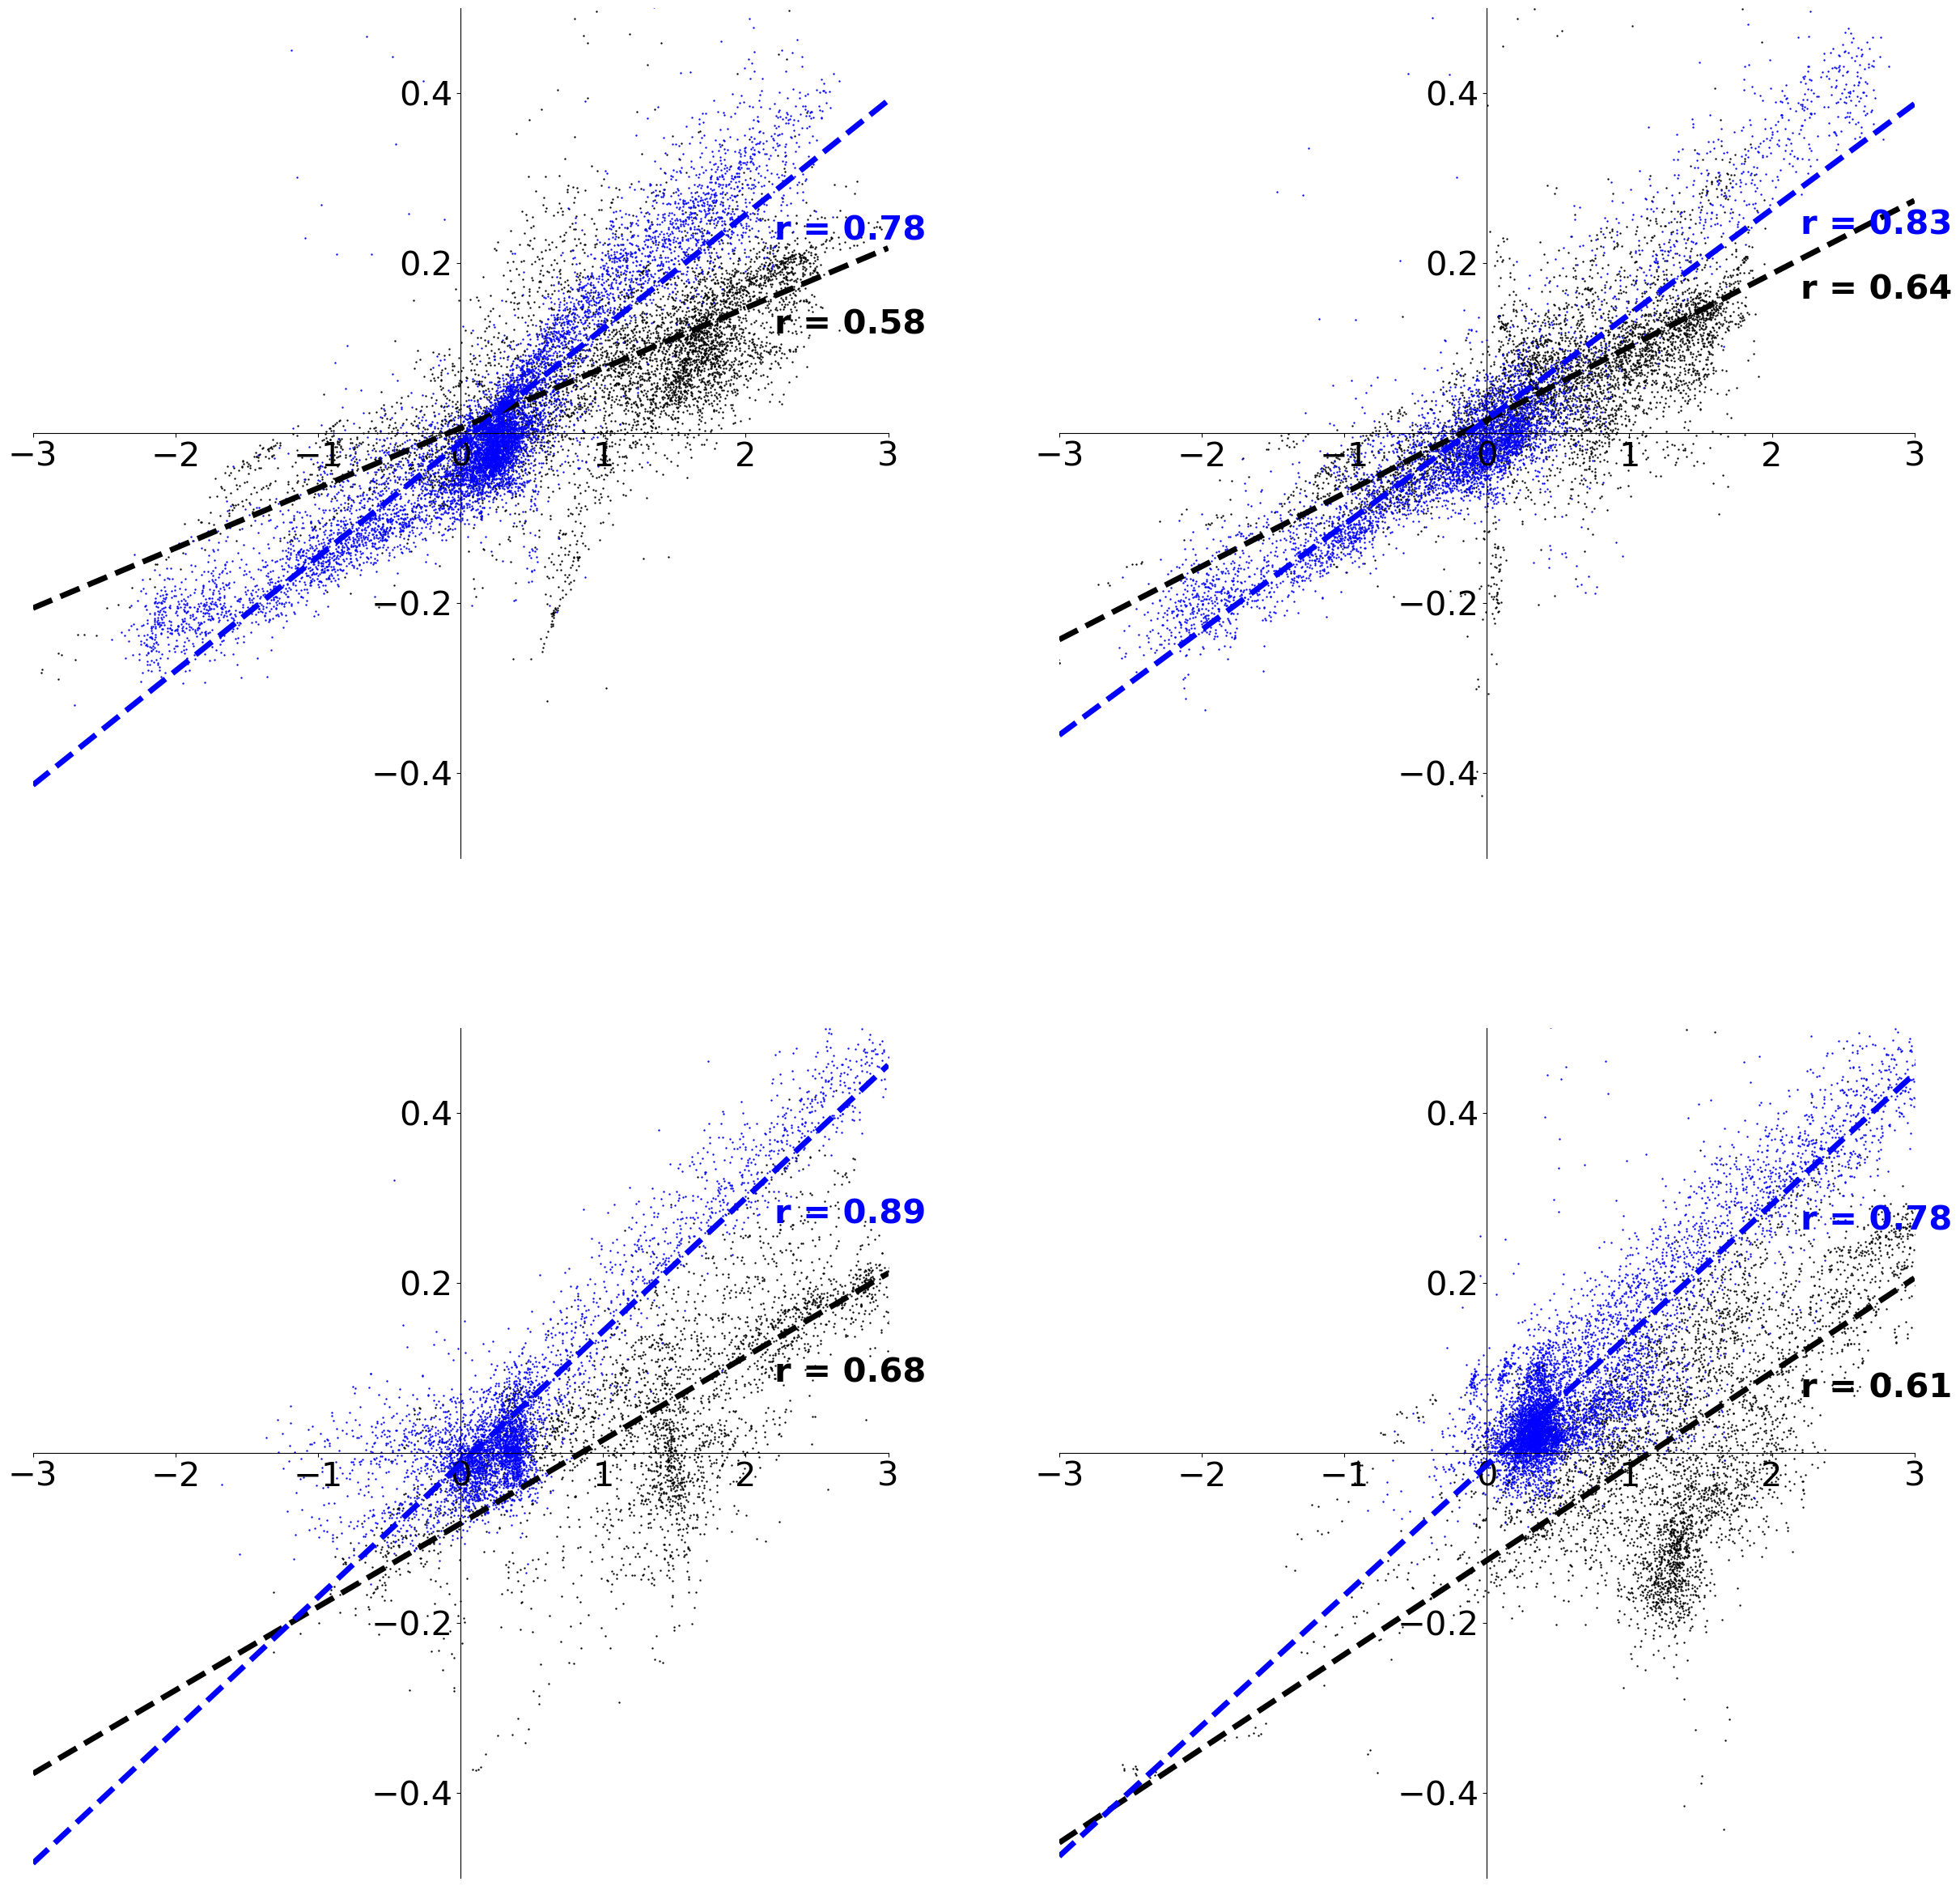

In [109]:
fig, ax = plt.subplots(figsize=(30,30), nrows= 2, ncols=2)

## SOhi
x = np.asarray(resT[0][0])
y = np.asarray(resS[0][0])
coef, stats = polyfit(x, y, 1, full=True)
poly1d_fn = Polynomial(coef) 
R2 = stats[0][0]
ax[0,0].scatter(x,y, s=0.5, c='k')
ax[0,0].plot([-3, 3], [poly1d_fn(-3), poly1d_fn(3)], '--k', lw=5) 
ax[0,0].annotate(f'r = {np.corrcoef(x, y)[0,1]:0.2f}',( 2+0.2, poly1d_fn(2)-0.03), 
                 fontsize=30, color='k', weight='bold')

x = np.asarray(resT[0][1])
y = np.asarray(resS[0][1])
coef, stats = polyfit(x, y, 1, full=True)
poly1d_fn = Polynomial(coef) 
R2 = stats[0][0]
ax[0,0].scatter(x,y, s=0.5, c='b')
ax[0,0].plot([-3, 3], [poly1d_fn(-3), poly1d_fn(3)], '--b', lw=5) 
ax[0,0].annotate(f'r = {np.corrcoef(x, y)[0,1]:0.2f}',( 2+0.2, poly1d_fn(2)-0.03), 
                 fontsize=30, color='b', weight='bold')

## LLC4320
x = np.asarray(resT[1][0])
y = np.asarray(resS[1][0])
coef, stats = polyfit(x, y, 1, full=True)
poly1d_fn = Polynomial(coef) 
R2 = stats[0][0]
ax[0,1].scatter(x,y, s=0.5, c='k')
ax[0,1].plot([-3, 3], [poly1d_fn(-3), poly1d_fn(3)], '--k', lw=5) 
ax[0,1].annotate(f'r = {np.corrcoef(x, y)[0,1]:0.2f}',( 2+0.2, poly1d_fn(2)-0.03), 
                 fontsize=30, color='k', weight='bold')

x = np.asarray(resT[1][1])
y = np.asarray(resS[1][1])
coef, stats = polyfit(x, y, 1, full=True)
poly1d_fn = Polynomial(coef) 
R2 = stats[0][0]
ax[0,1].scatter(x,y, s=0.5, c='b')
ax[0,1].plot([-3, 3], [poly1d_fn(-3), poly1d_fn(3)], '--b', lw=5) 
ax[0,1].annotate(f'r = {np.corrcoef(x, y)[0,1]:0.2f}',( 2+0.2, poly1d_fn(2)-0.03), 
                 fontsize=30, color='b', weight='bold')

## SOSE
x = np.asarray(resT[2][0])
y = np.asarray(resS[2][0])
coef, stats = polyfit(x, y, 1, full=True)
poly1d_fn = Polynomial(coef) 
R2 = stats[0][0]
ax[1,0].scatter(x,y, s=0.5, c='k')
ax[1,0].plot([-3, 3], [poly1d_fn(-3), poly1d_fn(3)], '--k', lw=5) 
ax[1,0].annotate(f'r = {np.corrcoef(x, y)[0,1]:0.2f}',( 2+0.2, poly1d_fn(2)-0.03), 
                 fontsize=30, color='k', weight='bold')

x = np.asarray(resT[2][1])
y = np.asarray(resS[2][1])
coef, stats = polyfit(x, y, 1, full=True)
poly1d_fn = Polynomial(coef) 
R2 = stats[0][0]
ax[1,0].scatter(x,y, s=0.5, c='b')
ax[1,0].plot([-3, 3], [poly1d_fn(-3), poly1d_fn(3)], '--b', lw=5) 
ax[1,0].annotate(f'r = {np.corrcoef(x, y)[0,1]:0.2f}',( 2+0.2, poly1d_fn(2)-0.03), 
                 fontsize=30, color='b', weight='bold')

## ECCO4
x = np.asarray(resT[3][0])
y = np.asarray(resS[3][0])
coef, stats = polyfit(x, y, 1, full=True)
poly1d_fn = Polynomial(coef) 
R2 = stats[0][0]
ax[1,1].scatter(x,y, s=0.5, c='k')
ax[1,1].plot([-3, 3], [poly1d_fn(-3), poly1d_fn(3)], '--k', lw=5) 
ax[1,1].annotate(f'r = {np.corrcoef(x, y)[0,1]:0.2f}',( 2+0.2, poly1d_fn(2)-0.03), 
                 fontsize=30, color='k', weight='bold')

x = np.asarray(resT[3][1])
y = np.asarray(resS[3][1])
coef, stats = polyfit(x, y, 1, full=True)
poly1d_fn = Polynomial(coef) 
R2 = stats[0][0]
ax[1,1].scatter(x,y, s=0.5, c='b')
ax[1,1].plot([-3, 3], [poly1d_fn(-3), poly1d_fn(3)], '--b', lw=5) 
ax[1,1].annotate(f'r = {np.corrcoef(x, y)[0,1]:0.2f}',( 2+0.2, poly1d_fn(2)-0.03), 
                 fontsize=30, color='b', weight='bold')

for a in ax.flat:
    a.set_ylim(-0.5, 0.5)
    a.set_xlim(-3,3)
    
    a.spines['left'].set_position('zero')
    a.spines['right'].set_color('none')
    a.yaxis.tick_left()
    a.spines['bottom'].set_position('zero')
    a.spines['top'].set_color('none')
    a.xaxis.tick_bottom()
    
    a.set_ylabel(' ', fontsize=25)
    a.set_xlabel(' ', fontsize=25)
    a.tick_params(axis='both', labelsize=30)
    
    a.set_yticks([-0.4, -0.2, 0.2, 0.4])
    
    plt.savefig('Correlation.png', dpi=300)

# Plot RMSE

In [20]:
SOhiT = swap(np.load("data1/SOhi_RMSET.npy"))
SOhiS = swap(np.load("data1/SOhi_RMSES.npy"))
LLCT = swap(np.load("data1/LLC_RMSET.npy"))
LLCS = swap(np.load("data1/LLC_RMSES.npy"))
SOSET = swap(np.load("data1/SOSE_RMSET.npy"))
SOSES = swap(np.load("data1/SOSE_RMSES.npy"))
ECCOT = swap(np.load("data1/ECCO_RMSET.npy"))
ECCOS = swap(np.load("data1/ECCO_RMSES.npy"))

resampled_mask = np.load("data/regridded/Mask.npy")

In [21]:
SOhiT = SOhiT * resampled_mask[None,:,:]
SOhiS = SOhiS * resampled_mask[None,:,:]

LLCT = LLCT * resampled_mask[None,:,:]
LLCS = LLCS * resampled_mask[None,:,:]

SOSET = SOSET * resampled_mask[None,:,:]
SOSES = SOSES * resampled_mask[None,:,:]

ECCOT = ECCOT * resampled_mask[None,:,:]
ECCOS = ECCOS * resampled_mask[None,:,:]

In [34]:
l1 = 0
l2 = 105*2
np.nanmean(SOhiT[20:40, :, l1:l2]), np.nanmean(LLCT[20:40, :, l1:l2]), np.nanmean(SOSET[20:40, :, l1:l2]), np.nanmean(ECCOT[20:40, :, l1:l2])

(1.3485917784266082, 0.7729852269793489, 1.453105628240612, 1.5012670806867046)

In [35]:
l1 = 105*2
l2 = 160*2
np.nanmean(SOhiT[20:40, :, l1:l2]), np.nanmean(LLCT[20:40, :, l1:l2]), np.nanmean(SOSET[20:40, :, l1:l2]), np.nanmean(ECCOT[20:40, :, l1:l2])

(1.0830807871573775, 1.043468682980087, 1.6826722423486236, 1.6027519783588777)

In [36]:
l1 = 242*2
l2 = 260*2
np.nanmean(SOhiT[20:40, :, l1:l2]), np.nanmean(LLCT[20:40, :, l1:l2]), np.nanmean(SOSET[20:40, :, l1:l2]), np.nanmean(ECCOT[20:40, :, l1:l2])

(1.0140477350103732,
 1.1796661058824778,
 1.3003396249124937,
 1.2978200227123597)

In [38]:
l1 = 160*2
l2 = 242*2
np.nanmean(SOhiT[20:40, :, l1:l2]), np.nanmean(LLCT[20:40, :, l1:l2]), np.nanmean(SOSET[20:40, :, l1:l2]), np.nanmean(ECCOT[20:40, :, l1:l2])

(0.5107628239792056,
 0.11380503879716956,
 0.319152349045386,
 0.7821351933154673)

In [37]:
l1 = 260*2
l2 = 300*2
np.nanmean(SOhiT[20:40, :, l1:l2]), np.nanmean(LLCT[20:40, :, l1:l2]), np.nanmean(SOSET[20:40, :, l1:l2]), np.nanmean(ECCOT[20:40, :, l1:l2])

(0.6143550473079348,
 0.773563873712156,
 0.29943885874218307,
 0.37600258773744205)